In [296]:
import os
import glob
import random
import multiprocessing
import copy
import pprint
from pathlib import Path
from typing import Optional, Union, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
from skimage.util import montage
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy import stats
import nrrd
import torch
import torchio as tio
import torchvision


seed = 2022

random.seed(seed)
torch.manual_seed(seed)
num_workers = multiprocessing.cpu_count()

In [69]:
path_data = os.path.join(os.getcwd(), '..', 'data')
path_eda = os.path.join(path_data, 'eda')
path_segmentation = os.path.join(path_data, 'segmentation_xyz')

In [70]:
df = pd.read_csv(os.path.join(path_eda, 'spect_data.csv'))

In [71]:
df.head()

image  image_slices  image_height  image_width                 mask  \
0  1.nrrd            62            64           64  1_Segmentation.nrrd   
1  2.nrrd            64            64           64  2_Segmentation.nrrd   
2  3.nrrd            64            64           64  3_Segmentation.nrrd   
3  4.nrrd            64            64           64                  NaN   
4  5.nrrd           128           128          128  5_Segmentation.nrrd   

   mask_slices  mask_height  mask_width  slices_positive  \
0         62.0         64.0        64.0             11.0   
1         64.0         64.0        64.0              9.0   
2         64.0         64.0        64.0             12.0   
3          NaN          NaN         NaN              NaN   
4        128.0        128.0       128.0             22.0   

   positive_pixels_ratio  positive_ratio positive_slice_ratio  
0               0.002788        0.177419               0.18 %  
1               0.001781        0.140625               0.14 %  
2               0.006973        0.187500               0.19 %  
3                    NaN             NaN                  NaN  
4               0.001923        0.171875               0.17 %

In [72]:
subjects = []

segmentations = list(df.loc[(df['mask'].notnull()), ['image', 'mask']].to_records(index=False))
segmentations = list(map(
    lambda x: (
        os.path.join(path_segmentation, x[0]),
        os.path.join(path_segmentation, x[1])
    ), 
    segmentations
))

for image_path, label_path in segmentations:
    
    subject = tio.Subject(
        spect=tio.ScalarImage(image_path),
        left_ventricle=tio.LabelMap(label_path)
    )
    subjects.append(subject)

dataset = tio.SubjectsDataset(subjects)
print(f"Dataset size: {len(dataset)} subjects")

Dataset size: 10 subjects


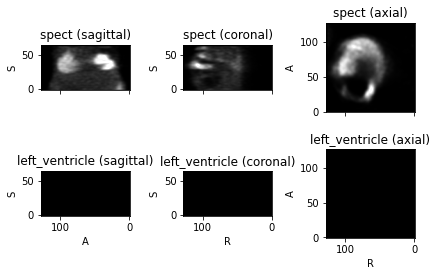

In [73]:
one_subject = dataset[0]

one_subject.plot()

In [74]:
print(one_subject)
print(one_subject.spect)
print(one_subject.left_ventricle)

Subject(Keys: ('spect', 'left_ventricle'); images: 2)
ScalarImage(shape: (1, 128, 128, 64); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.IntTensor; memory: 4.0 MiB)
LabelMap(shape: (1, 128, 128, 64); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.ByteTensor; memory: 1.0 MiB)


In [153]:
class Visualizer:
    
    def montage_nrrd(self, image):
        if len(image.shape) > 2:
            return montage(image)
        else:
            warnings.warn('Pass a 3D volume', RuntimeWarning)
            return image
        
    def visualize(self, image, mask=None):
        
        if mask is None:
            fig, axes = plt.subplots(1, 1, figsize=(10, 10))
            axes.imshow(self.montage_nrrd(image))
            axes.set_axis_off()
        else:
            fig, axes = plt.subplots(1, 2, figsize=(40, 40))
        
            for i, data in enumerate([image, mask]):
                axes[i].imshow(self.montage_nrrd(data))
                axes[i].set_axis_off()
                
                
vis = Visualizer()

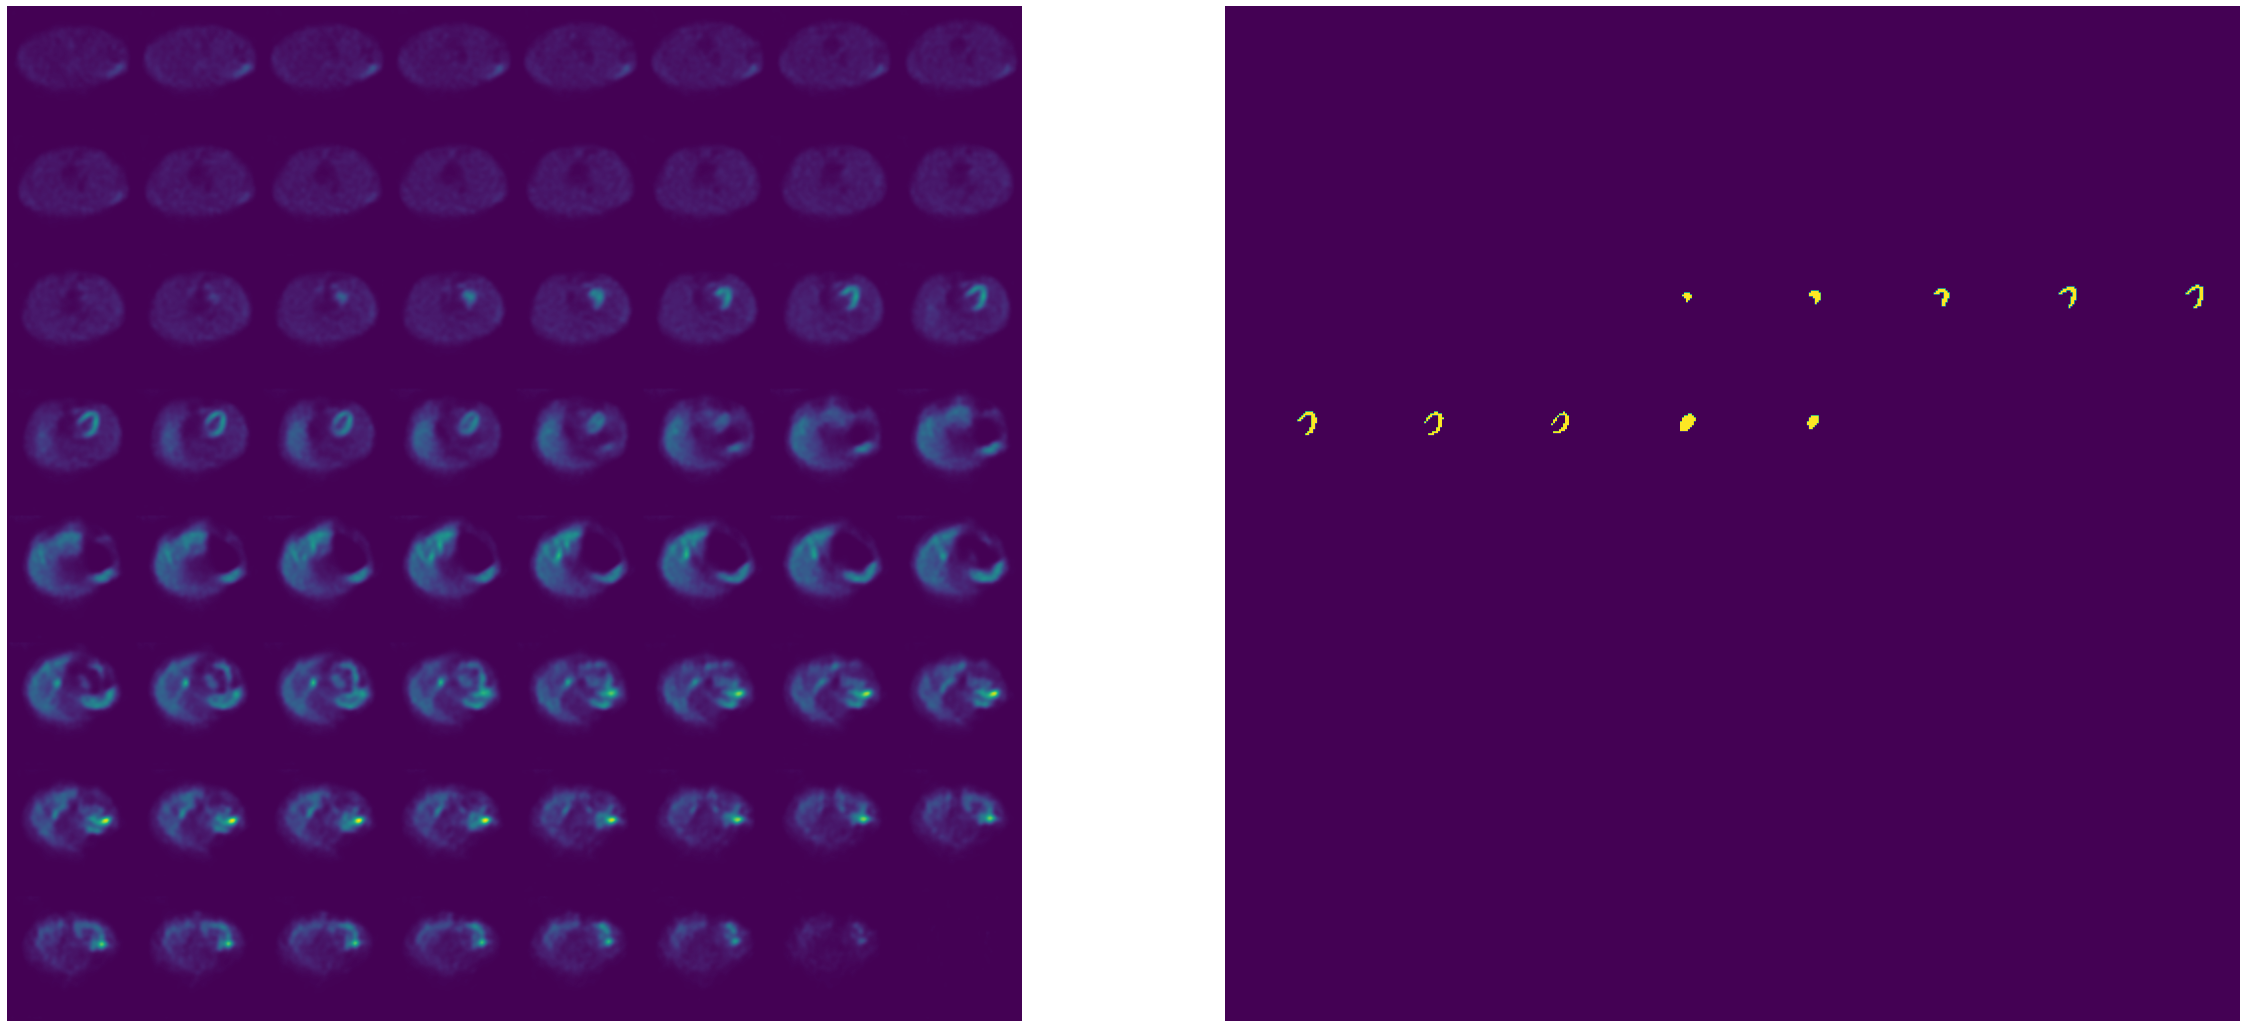

In [154]:
image, mask = one_subject.spect.data.numpy(), one_subject.left_ventricle.data.numpy()

image = np.squeeze(image).swapaxes(1, 2).swapaxes(0, 1)
mask = np.squeeze(mask).swapaxes(1, 2).swapaxes(0, 1)

vis.visualize(image, mask)

In [21]:
def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    
    if label is not None:
        kwargs['label'] = label
    
    axis.plot(positions, histogram, **kwargs)

In [36]:
image_paths = df['image'].apply(lambda x: os.path.join(path_segmentation, x)).tolist()

  0%|          | 0/102 [00:00<?, ?it/s]

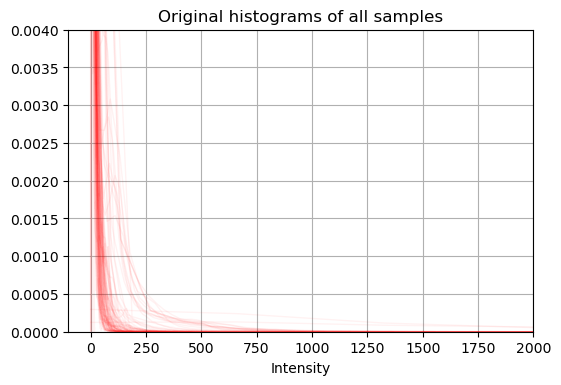

In [37]:
fig, ax = plt.subplots(dpi=100)

for path in tqdm(image_paths):

    tensor = tio.ScalarImage(path).data
    color = 'red'

    plot_histogram(ax, tensor, color=color)

ax.set_xlim(-100, 2000)
ax.set_ylim(0, 0.004);
ax.set_title('Original histograms of all samples')
ax.set_xlabel('Intensity')
ax.grid()

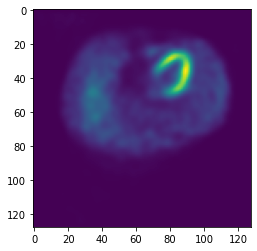

In [103]:
plt.imshow(one_subject.spect.data.numpy()[0, ..., 24])

In [104]:
print(one_subject.spect)

ScalarImage(shape: (1, 128, 128, 64); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.IntTensor; memory: 4.0 MiB)


## Check orientation? wtf?

In [121]:
for image_path, label_path in segmentations:
    
    image, head = nrrd.read(image_path)
    mask, head = nrrd.read(label_path)
    
    image = np.expand_dims(np.flip(image, axis=2).astype('float32'), axis=0)
    mask =np.expand_dims(np.flip(mask, axis=2).astype('float32'), axis=0)
    
    subject_test = tio.Subject(
        spect=tio.ScalarImage(tensor=torch.tensor(image)),
        left_ventricle=tio.LabelMap(tensor=torch.tensor(mask))
    )
    
    break

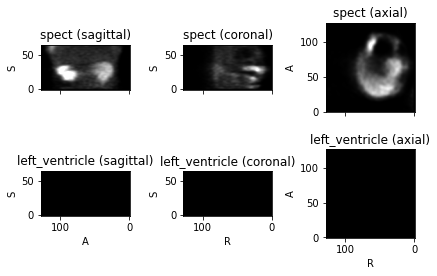

In [122]:
subject_test.plot()

In [149]:
image, mask = one_subject.spect.data.numpy(), one_subject.left_ventricle.data.numpy()

print(f"Image shape is: {image.shape}")
print(f"Mask shape is: {mask.shape}")

Image shape is: (1, 128, 128, 64)
Mask shape is: (1, 128, 128, 64)


In [150]:
target_shape = (128, 128, 32)

crop_pad = tio.CropOrPad(target_shape)

image_cropped = crop_pad(image)

In [151]:
image_cropped.shape

(1, 128, 128, 32)

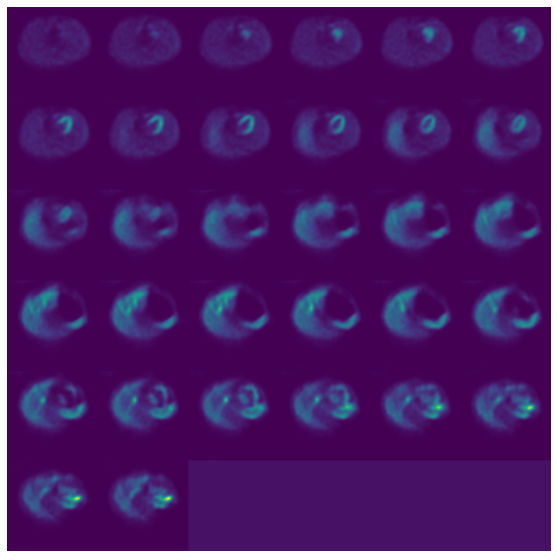

In [155]:
vis.visualize(np.squeeze(image_cropped).swapaxes(1, 2).swapaxes(0, 1))

Image shape is: (1, 128, 128, 32)
Mask shape is: (1, 128, 128, 32)


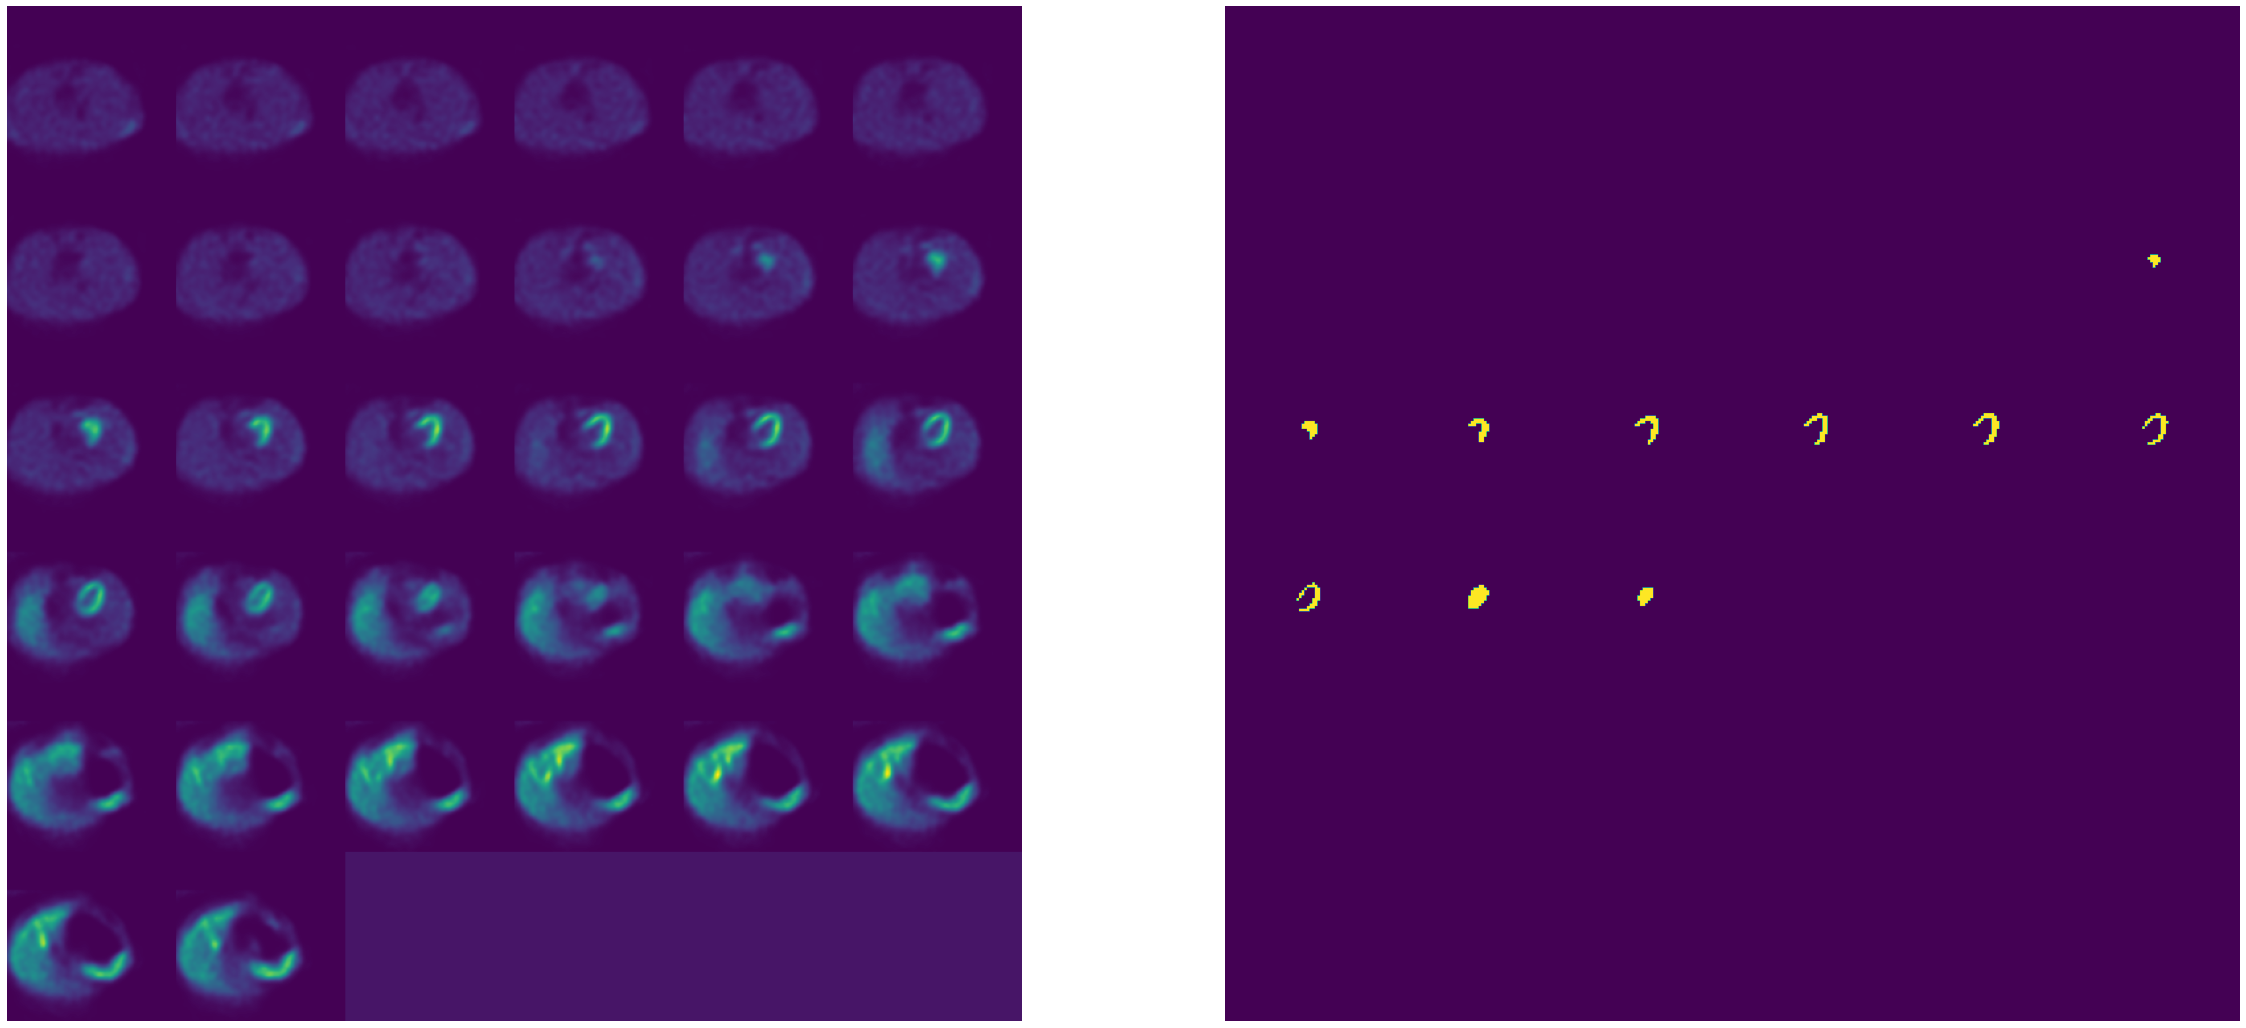

In [161]:
target_shape = (128, 128, 32)

crop_pad = tio.CropOrPad(target_shape, mask_name='left_ventricle')

one_subject_cropped = crop_pad(one_subject)

image_cropped = one_subject_cropped.spect.data.numpy()
mask_cropped = one_subject_cropped.left_ventricle.data.numpy()

print(f"Image shape is: {image_cropped.shape}")
print(f"Mask shape is: {mask_cropped.shape}")

vis.visualize(
    np.squeeze(image_cropped).swapaxes(1, 2).swapaxes(0, 1), 
    np.squeeze(mask_cropped).swapaxes(1, 2).swapaxes(0, 1)
)

## Used random crop for self-supervised training

In [162]:
random_crop = tio.data.UniformSampler(target_shape)

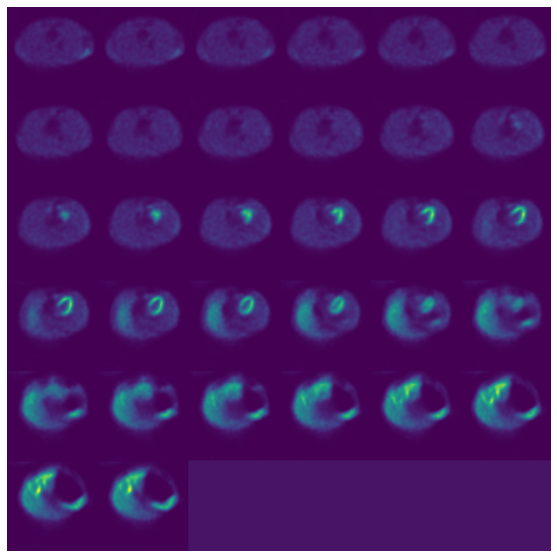

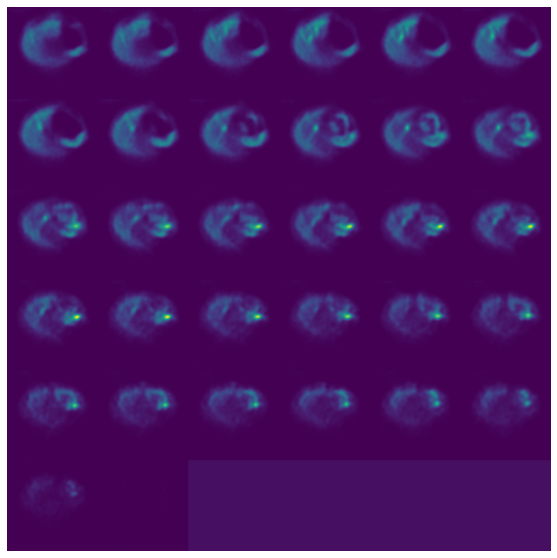

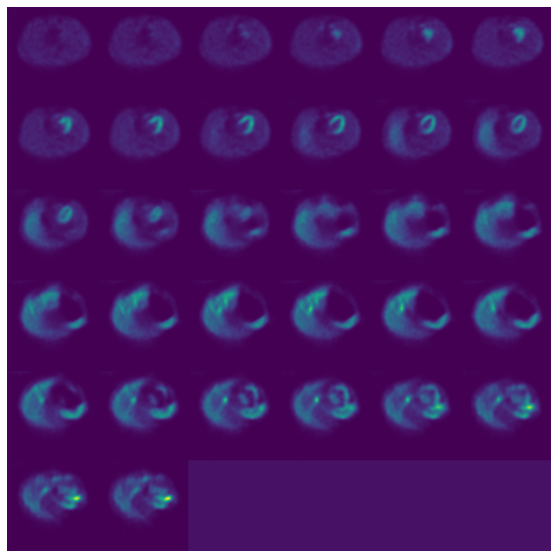

In [176]:
image, mask = one_subject.spect.data.numpy(), one_subject.left_ventricle.data.numpy()

image_cropped = next(random_crop(subject=one_subject, num_patches=1)).spect.data.numpy()

vis.visualize(np.squeeze(image_cropped).swapaxes(1, 2).swapaxes(0, 1))

image_cropped = next(random_crop(subject=one_subject, num_patches=1)).spect.data.numpy()

vis.visualize(np.squeeze(image_cropped).swapaxes(1, 2).swapaxes(0, 1))

image_cropped = next(random_crop(subject=one_subject, num_patches=1)).spect.data.numpy()

vis.visualize(np.squeeze(image_cropped).swapaxes(1, 2).swapaxes(0, 1))

In [275]:
# https://github.com/fepegar/torchio/issues/570

class RandomCrop:
    """Random cropping on subject."""

    def __init__(self, target_shape: Tuple, label: str = None):
        """Init.

        Args:
            roi_size: cropping size.
        """
        self.sampler = tio.data.LabelSampler(patch_size=roi_size, label_name=label)

    def __call__(self, subject: tio.Subject) -> tio.Subject:
        """Use patch sampler to crop.

        Args:
            subject: subject having image and label.

        Returns:
            cropped subject
        """
        for patch in self.sampler(subject=subject, num_patches=1):
            return patch

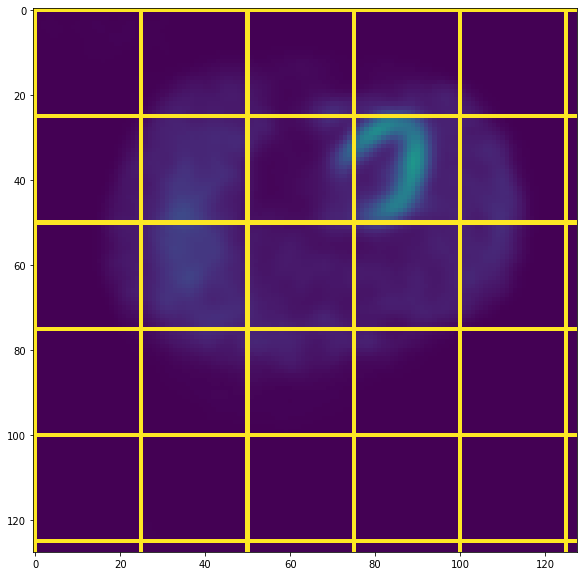

In [214]:
image_test = copy.deepcopy(image)

white = image_test.max()
N = 25
slice_idx = 24

image_test[:, ::N, :, :] = white
image_test[:, :, ::N, :] = white

plt.figure(figsize=(10, 10))
plt.imshow(image_test[0, :, :, slice_idx])

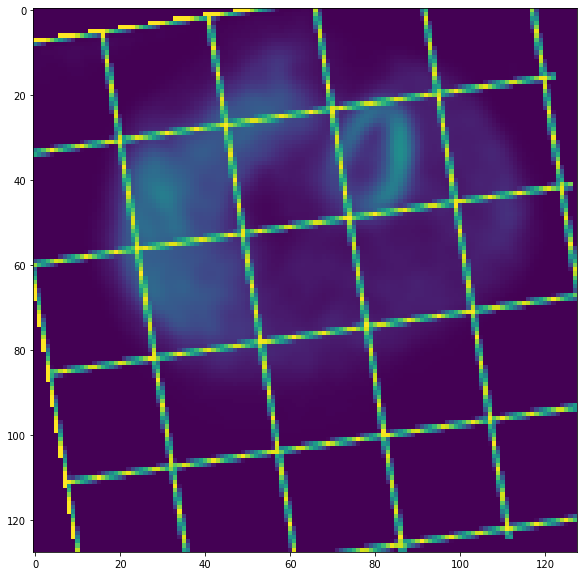

In [220]:
random_affine = tio.RandomAffine()

image_affine = random_affine(image_test)

plt.figure(figsize=(10, 10))
plt.imshow(image_affine[0, :, :, slice_idx])

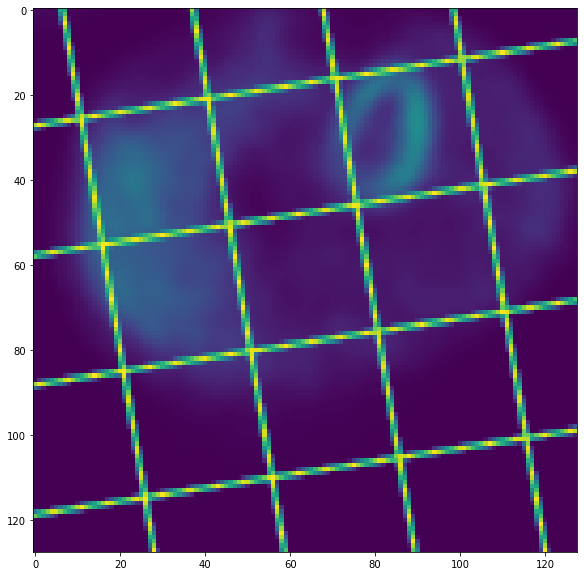

In [223]:
random_affine_zoom = tio.RandomAffine(scales=(1.2, 1.2))

image_affine = random_affine_zoom(image_test)

plt.figure(figsize=(10, 10))
plt.imshow(image_affine[0, :, :, slice_idx])

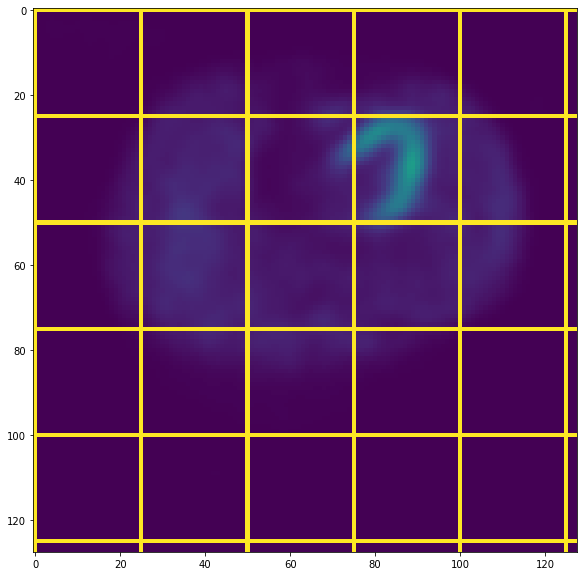

In [232]:
random_flip = tio.RandomFlip(axes=['inferior-superior'], flip_probability=1)

image_flipped = random_flip(image_test)

plt.figure(figsize=(10, 10))
plt.imshow(image_flipped[0, :, :, -slice_idx])

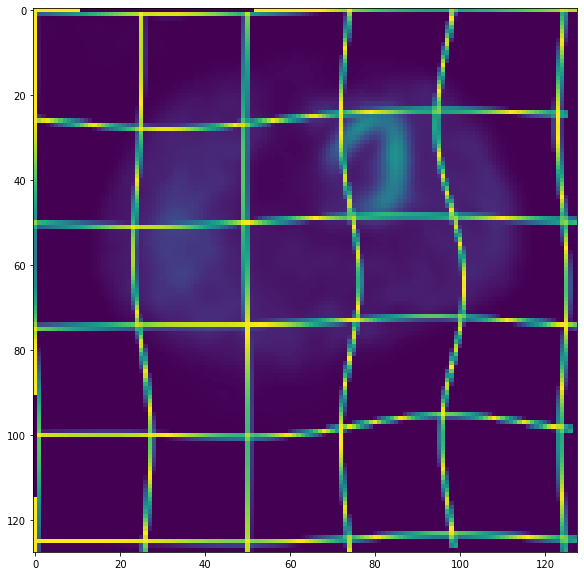

In [240]:
max_displacement = (15, 20, 0)

random_elastic = tio.RandomElasticDeformation(max_displacement=max_displacement)

image_elastic = random_elastic(image_test)

plt.figure(figsize=(10, 10))
plt.imshow(image_elastic[0, :, :, slice_idx])

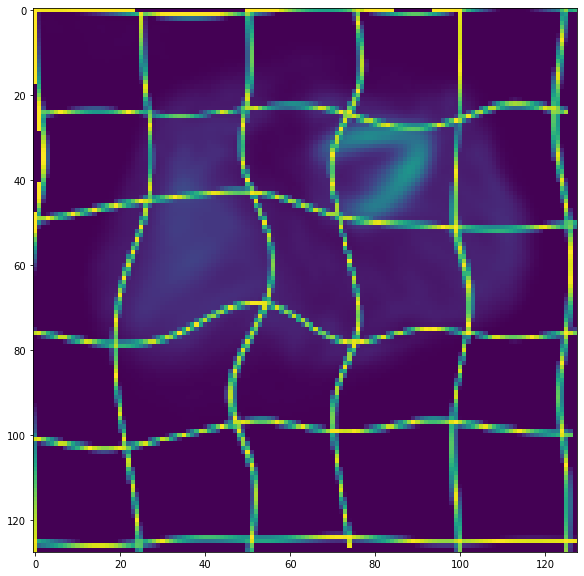

In [244]:
random_elastic = tio.RandomElasticDeformation(
    max_displacement=max_displacement,
    num_control_points=10,
)

image_elastic = random_elastic(image_test)

plt.figure(figsize=(10, 10))
plt.imshow(image_elastic[0, :, :, slice_idx])

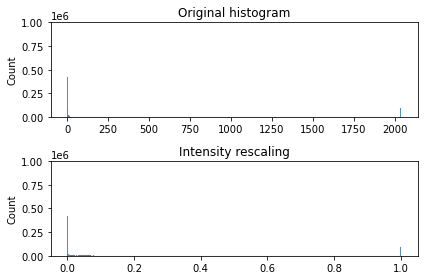

In [249]:
rescale = tio.RescaleIntensity((0, 1))

image_rescaled = rescale(image_test)

fig, axes = plt.subplots(2, 1)

sns.histplot(image_test.flatten(), ax=axes[0], kde=False)
sns.histplot(image_rescaled.flatten(), ax=axes[1], kde=False)

axes[0].set_title('Original histogram')
axes[1].set_title('Intensity rescaling')
axes[0].set_ylim((0, 1e6))
axes[1].set_ylim((0, 1e6))
plt.tight_layout()

In [254]:
image_rescaled.min()

0.0

In [255]:
image_rescaled.max()

1.0

In [261]:
standardize = tio.ZNormalization()

image_standardized = standardize(image_test)

print(f"Image min: {image_standardized.min():.4f}")
print(f"Image max: {image_standardized.max():.4f}")
print(f"Image mean: {image_standardized.mean():.4f}")
print(f"Image variance: {image_standardized.var():.4f}")

Image min: -0.4338
Image max: 3.0615
Image mean: 0.0000
Image variance: 1.0000


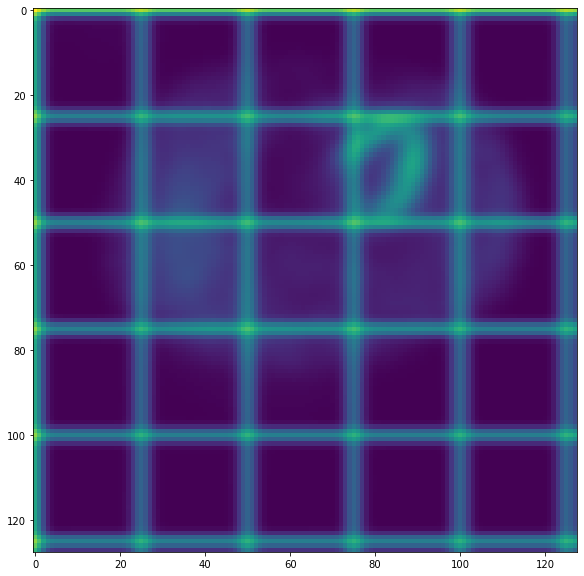

In [263]:
blur = tio.RandomBlur()

image_blurred = blur(image_test)

plt.figure(figsize=(10, 10))
plt.imshow(image_blurred[0, :, :, slice_idx])

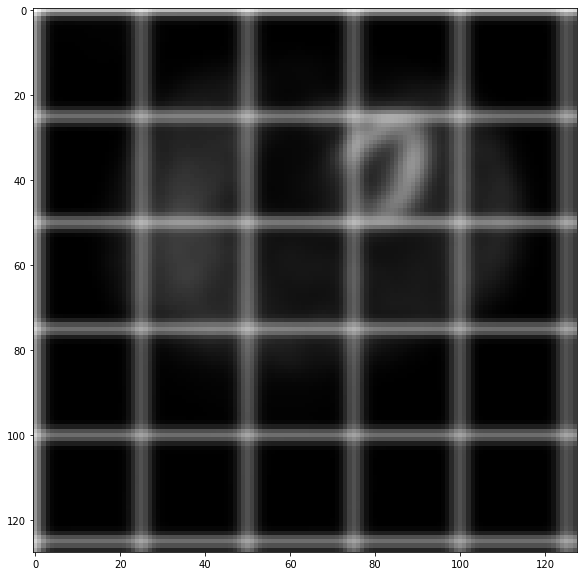

In [267]:
add_noise = tio.RandomNoise(std=0.5)

image_standard = standardize(image_test)
image_noisy = add_noise(image_standard)

plt.figure(figsize=(10, 10))
plt.imshow(image_blurred[0, :, :, slice_idx], cmap='gray')

Applied transformations:
[Resample(target=(4.826290130615234, 1.0, 1.0), image_interpolation=nearest, label_interpolation=nearest, pre_affine_name=None, scalars_only=True),
 Resample(target=((128, 128, 64), array([[-1.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])), image_interpolation=linear, label_interpolation=nearest, pre_affine_name=None, scalars_only=True)]


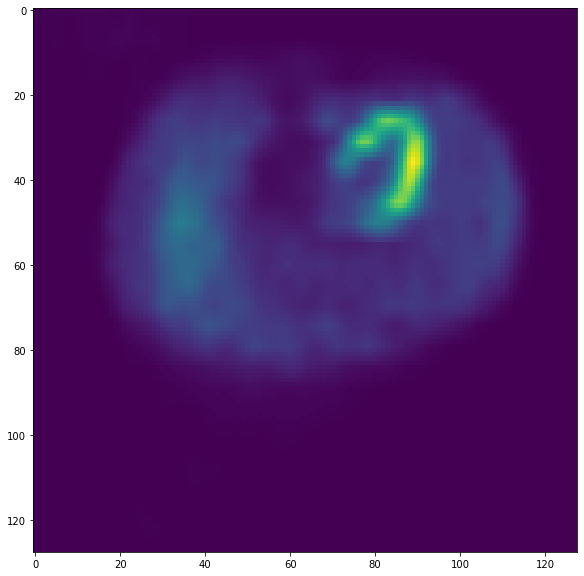

In [274]:
random_anisotropy = tio.RandomAnisotropy()

subject_anisotropic = random_anisotropy(one_subject)

print("Applied transformations:")
pprint.pprint(subject_anisotropic.history)

plt.figure(figsize=(10, 10))
plt.imshow(subject_anisotropic.spect.data.numpy()[0, :, :, slice_idx])

In [316]:
max_displacement = (8, 8, 0)
num_control_points = 10


transformations = tio.Compose([
    tio.CropOrPad(target_shape=target_shape, mask_name="left_ventricle"),
    tio.ZNormalization(),
    tio.RandomFlip(p=0.25),
    tio.OneOf({
        tio.RandomAnisotropy(p=0.5),
        tio.RandomBlur(p=0.5),
        tio.RandomNoise(p=0.5),  
    }, p=0.5),
    tio.OneOf({
        tio.RandomAffine(): 0.6,
        tio.RandomElasticDeformation(max_displacement=max_displacement): 0.2,
        tio.RandomElasticDeformation(
            max_displacement=max_displacement,
            num_control_points=num_control_points
        ): 0.2
    }, p=0.8)
])

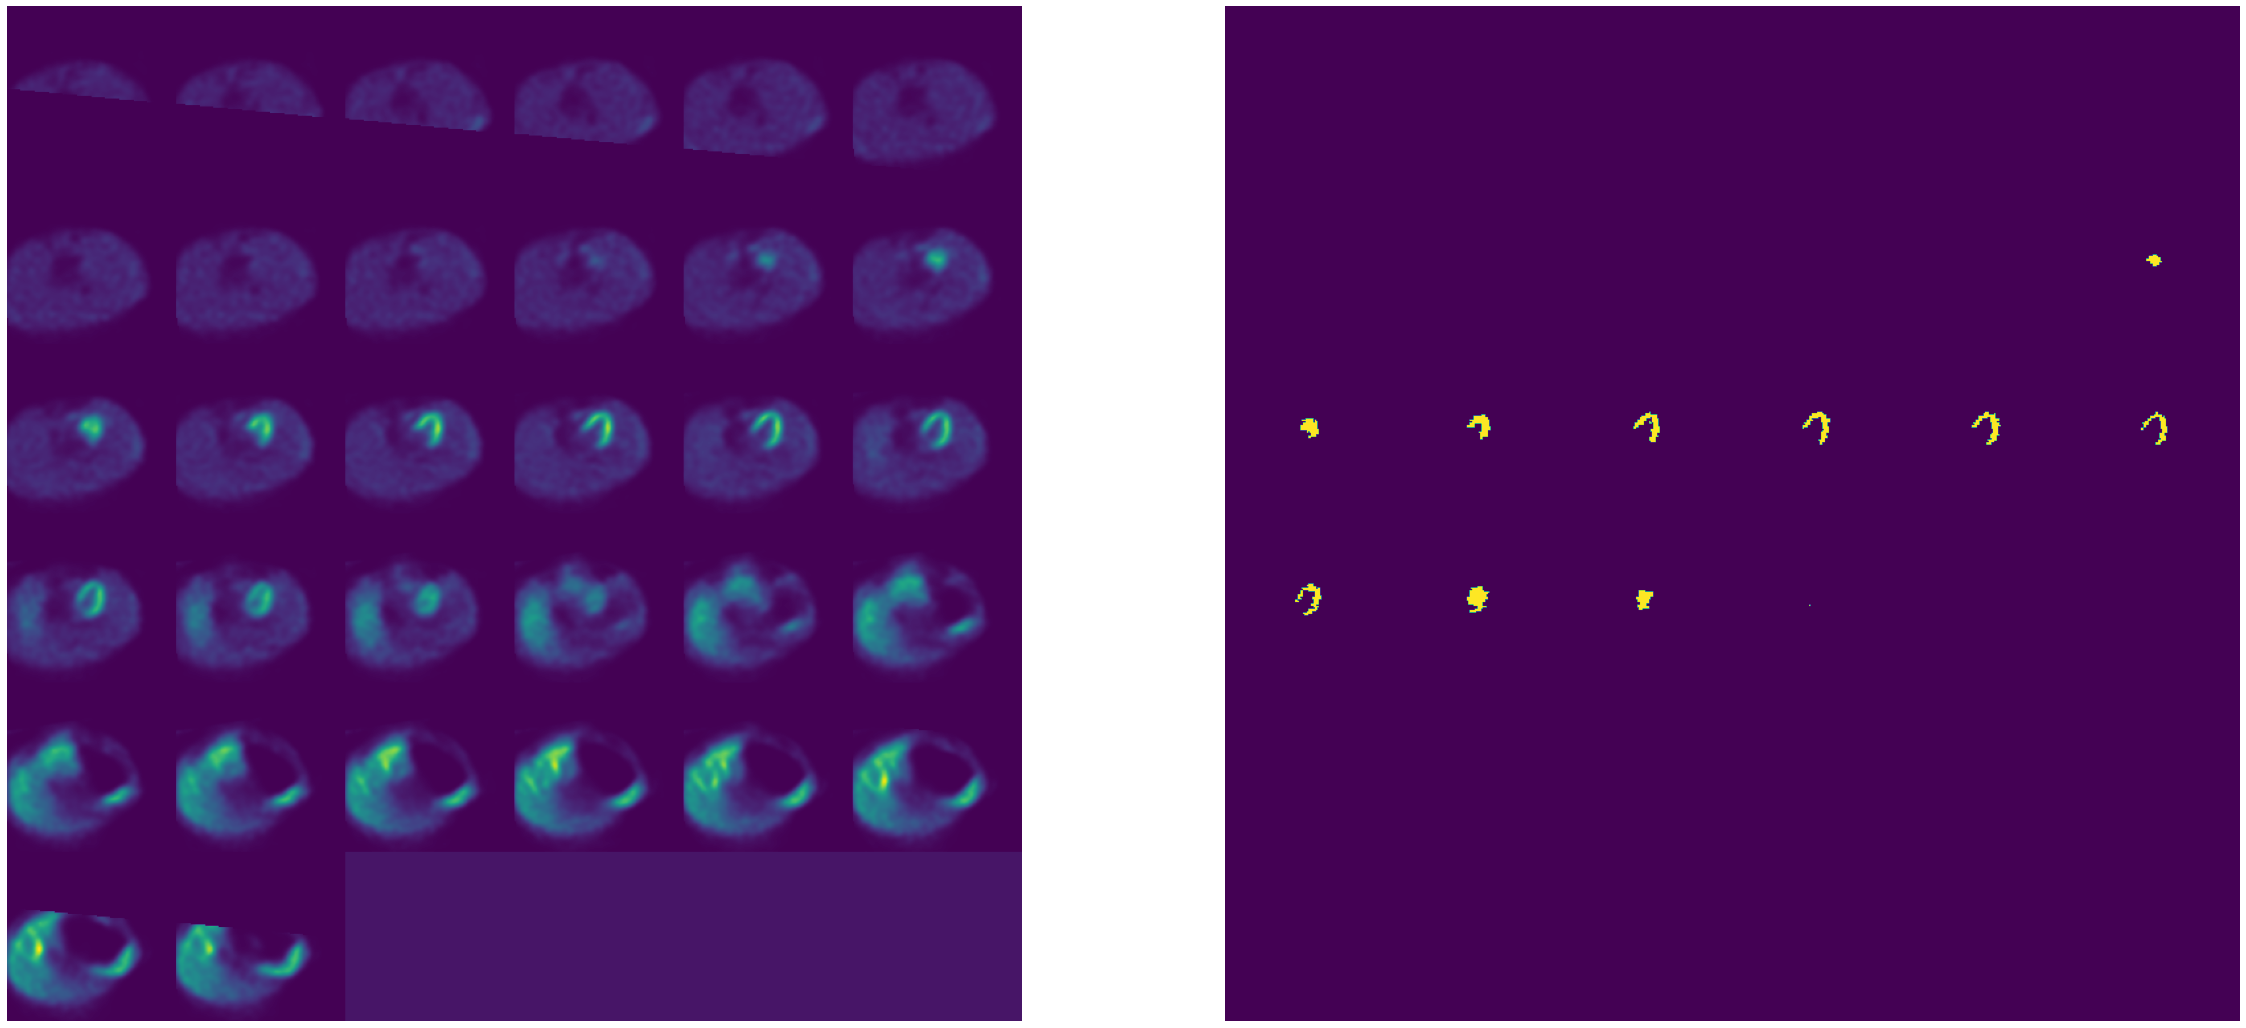

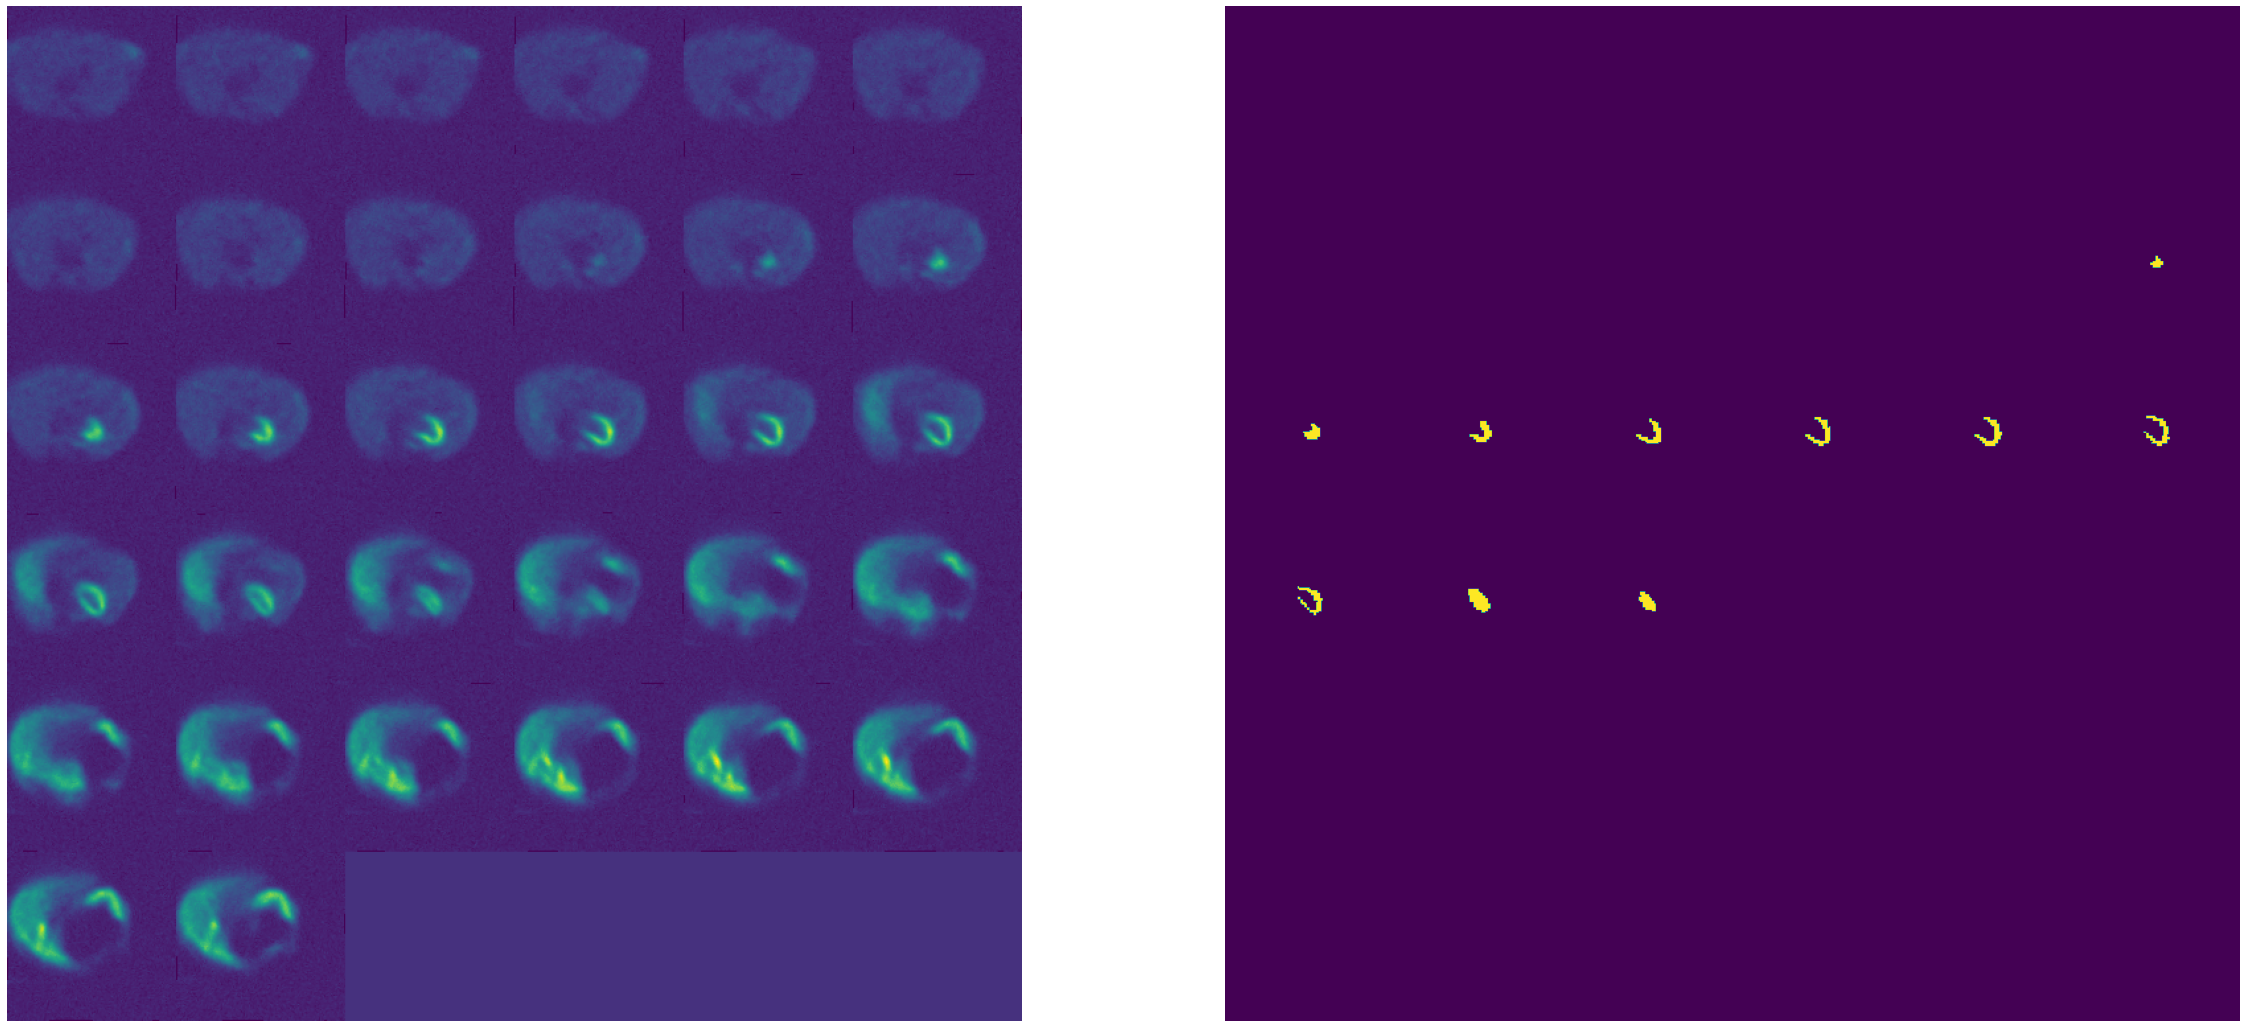

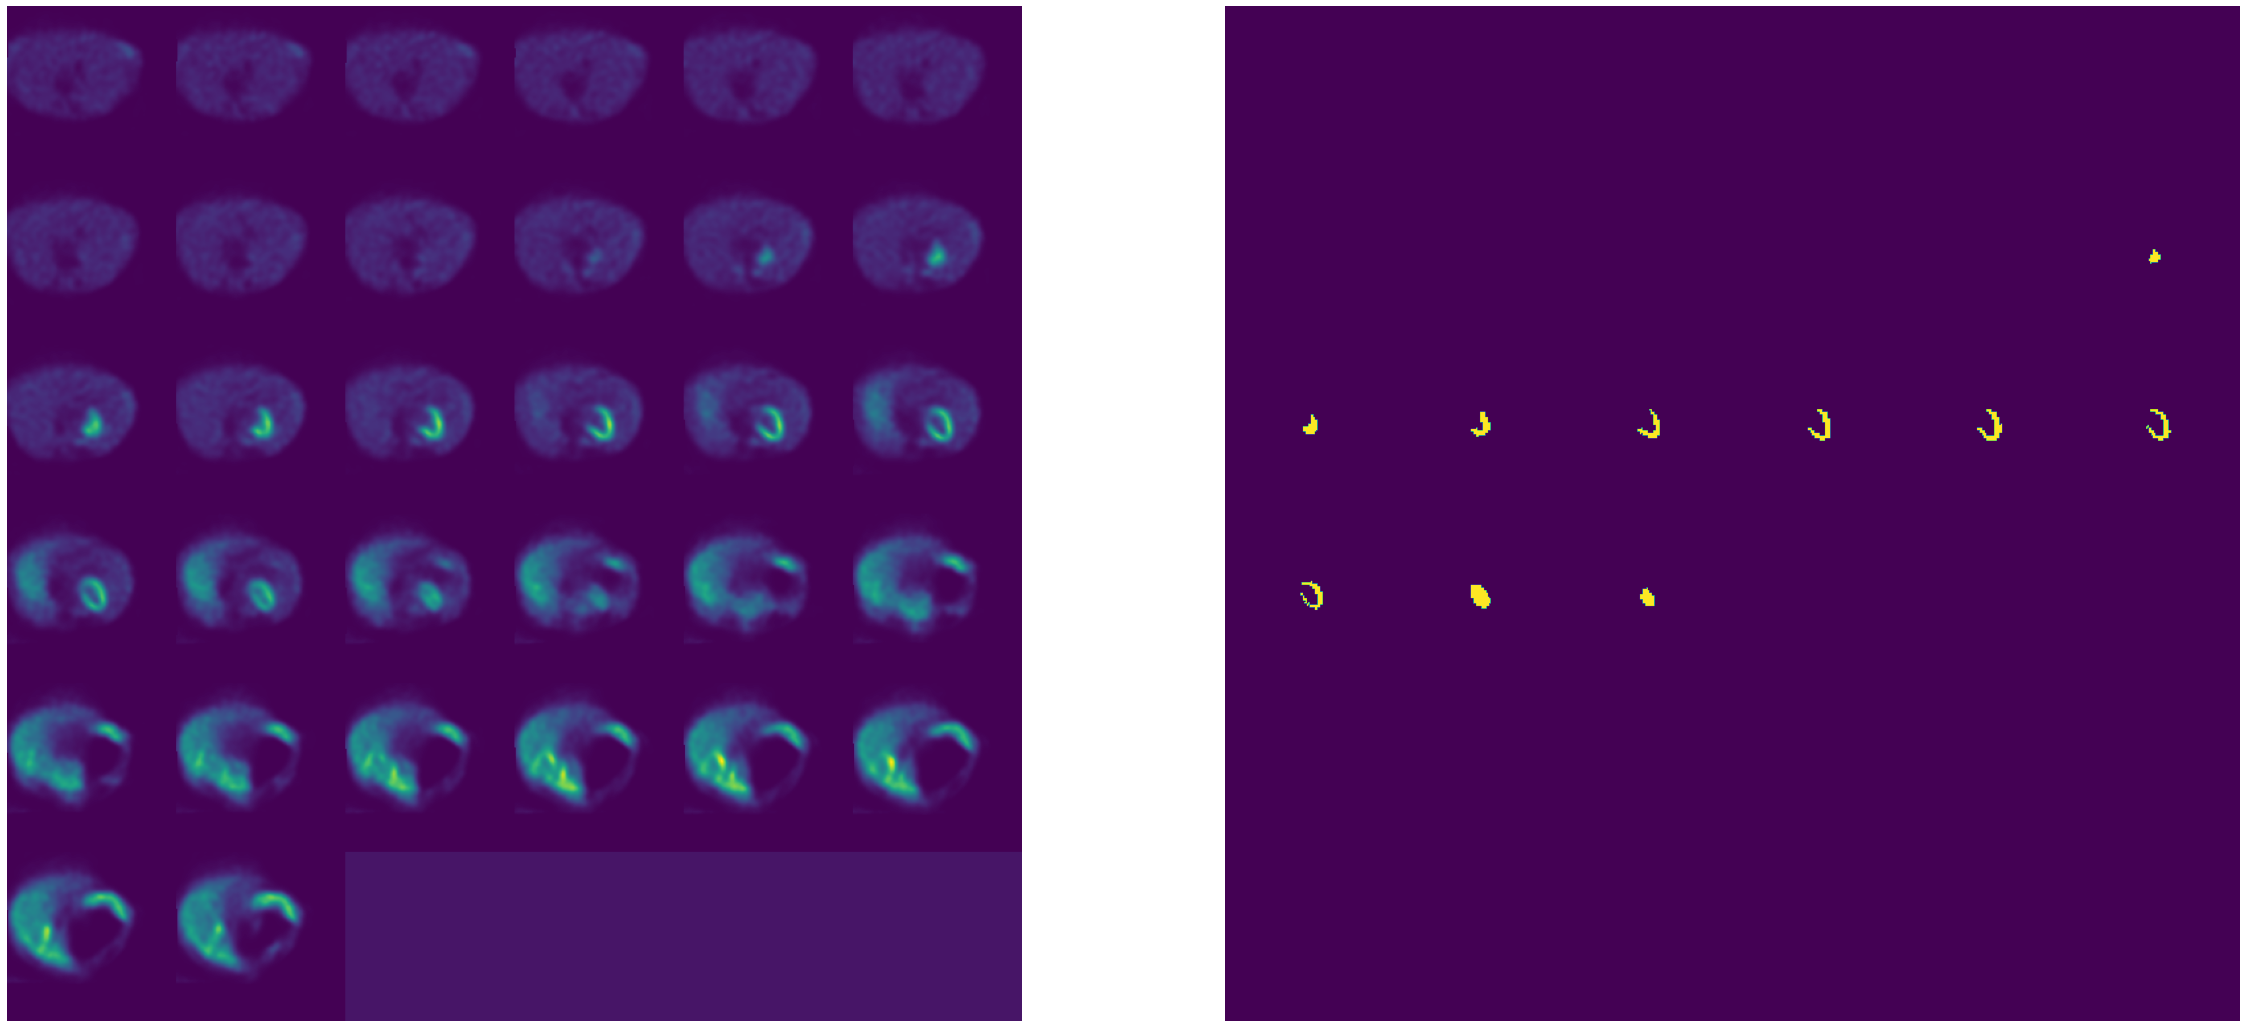

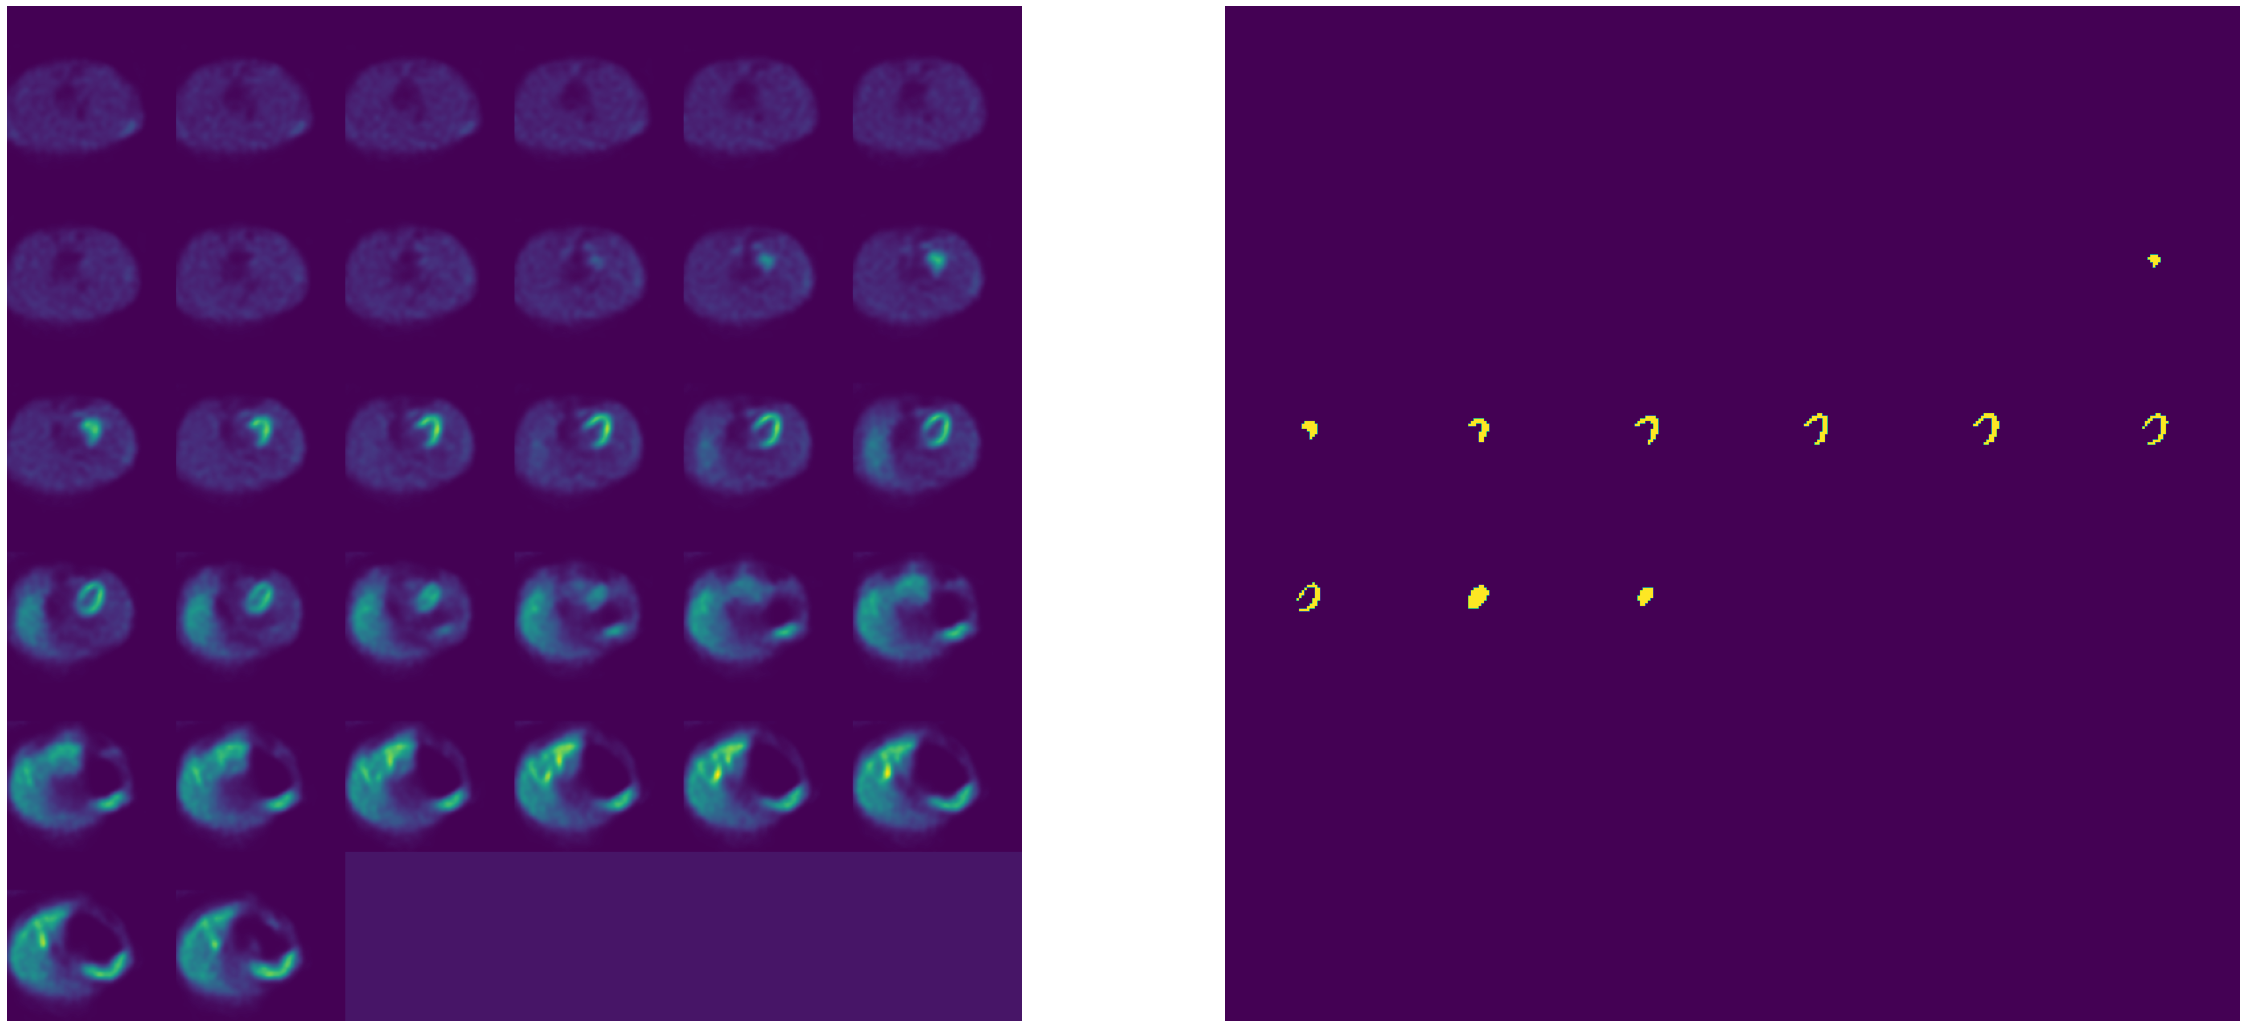

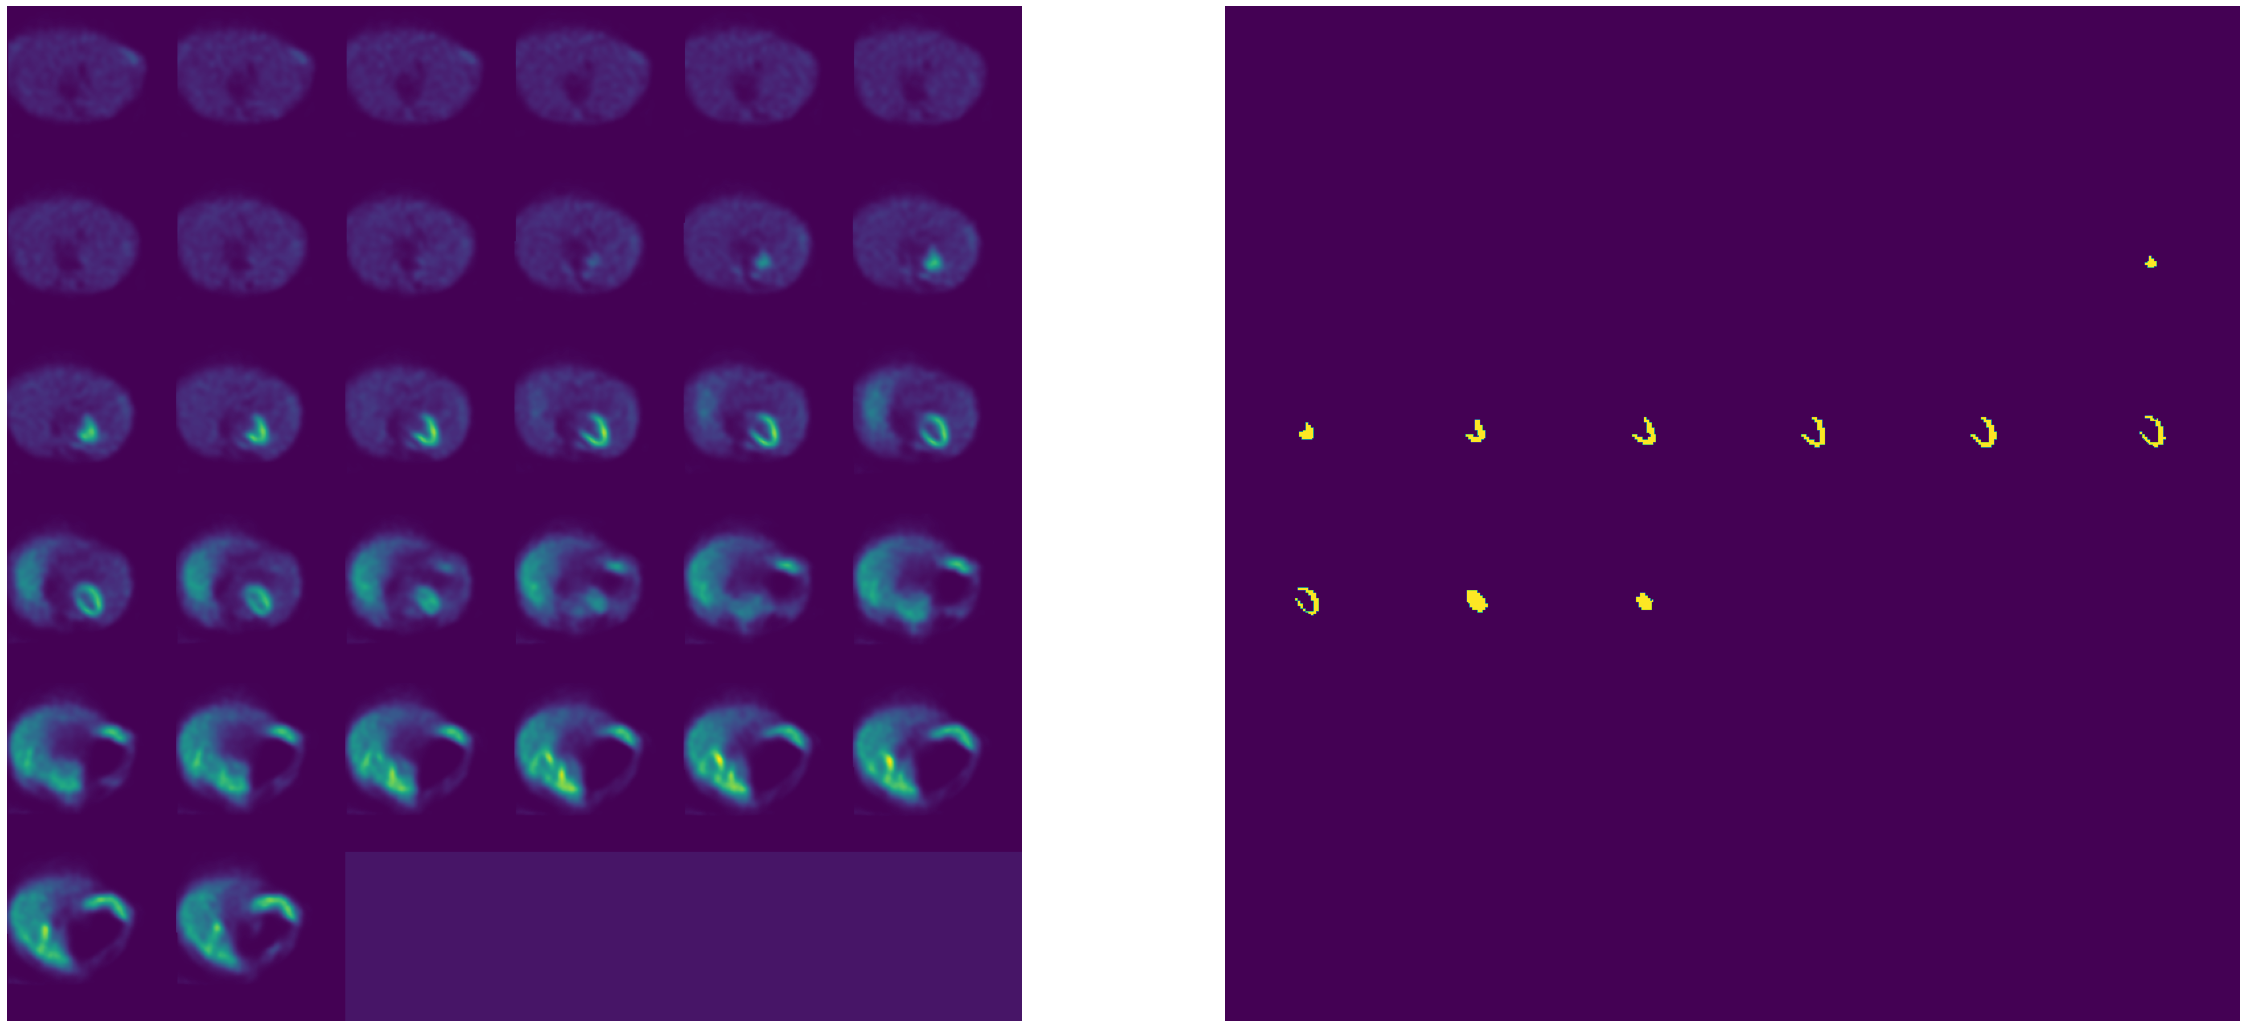

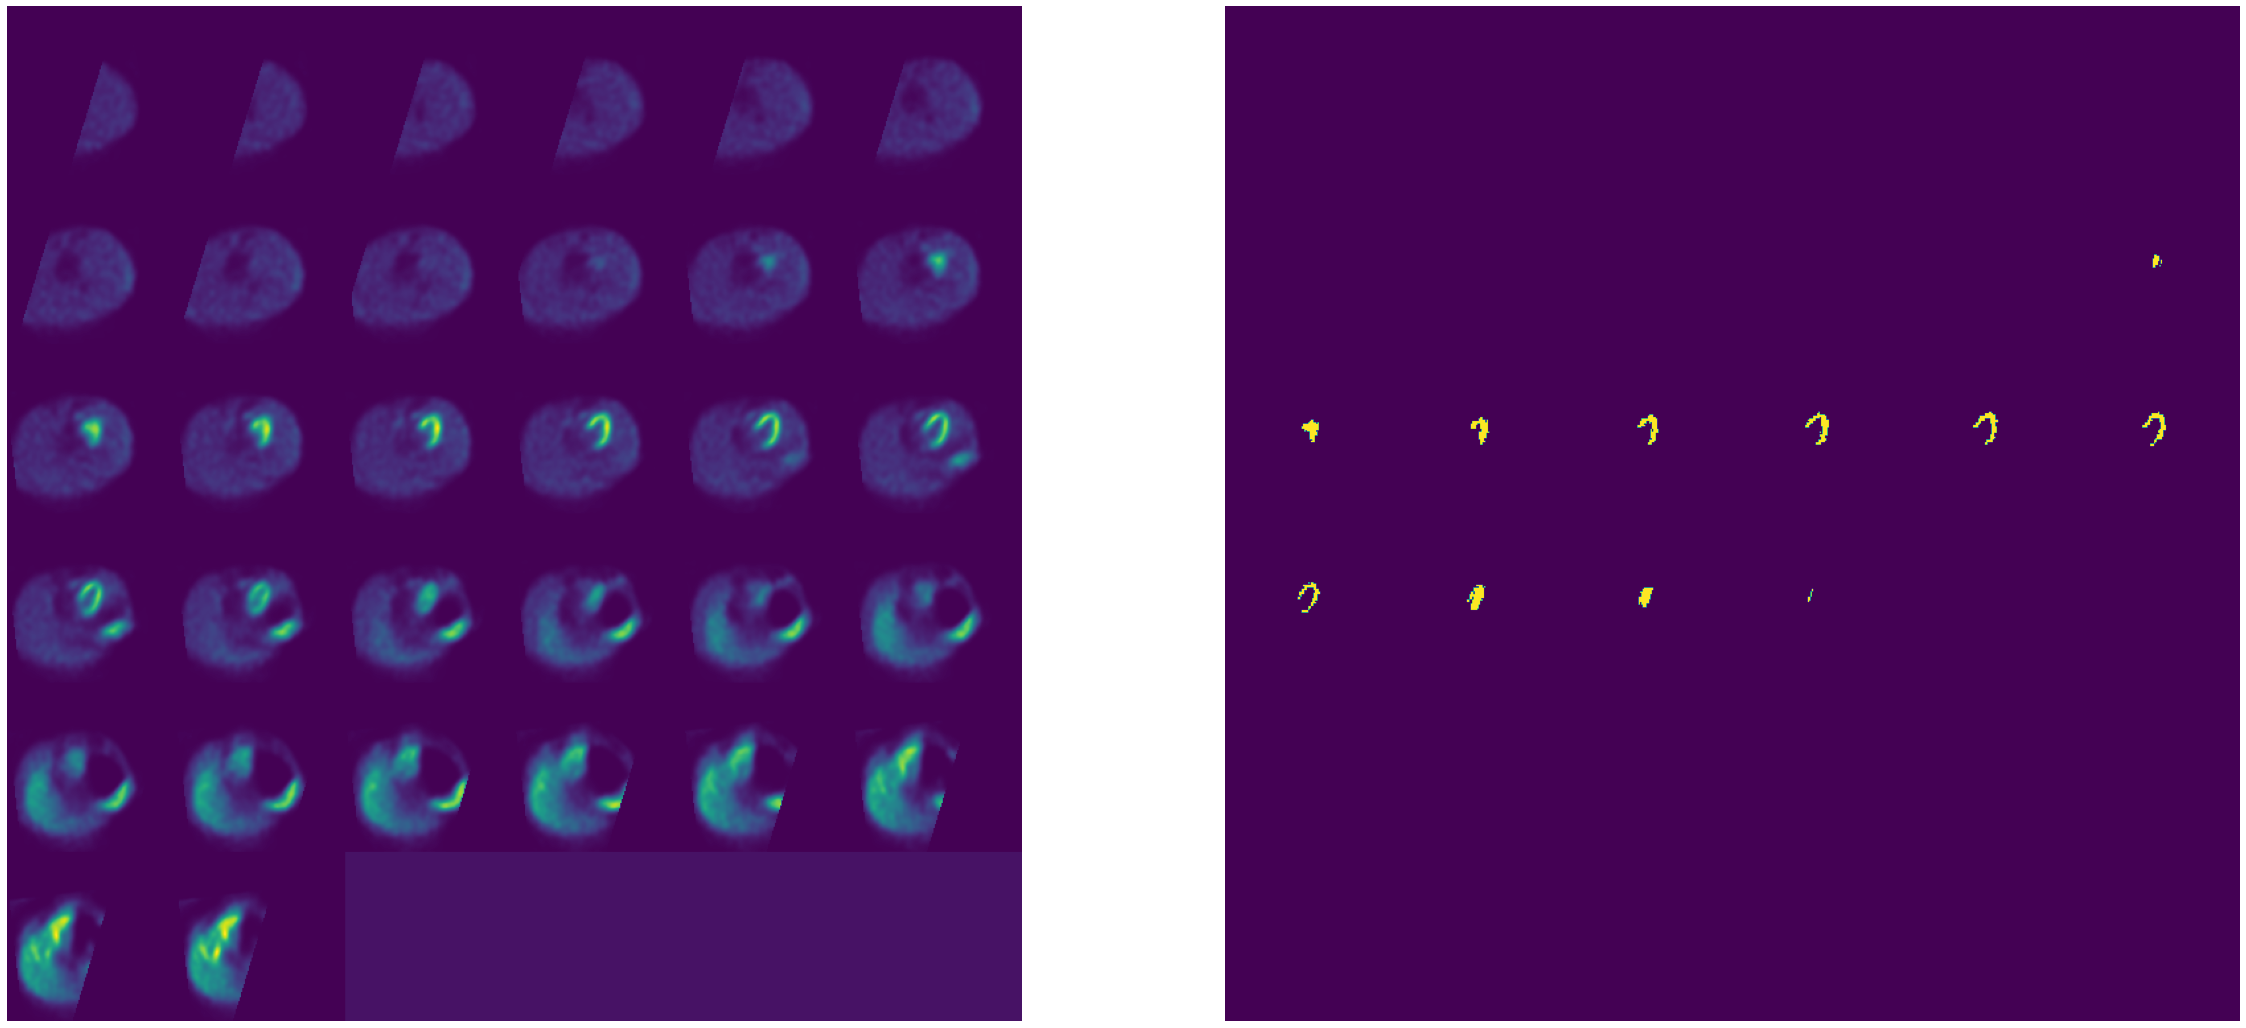

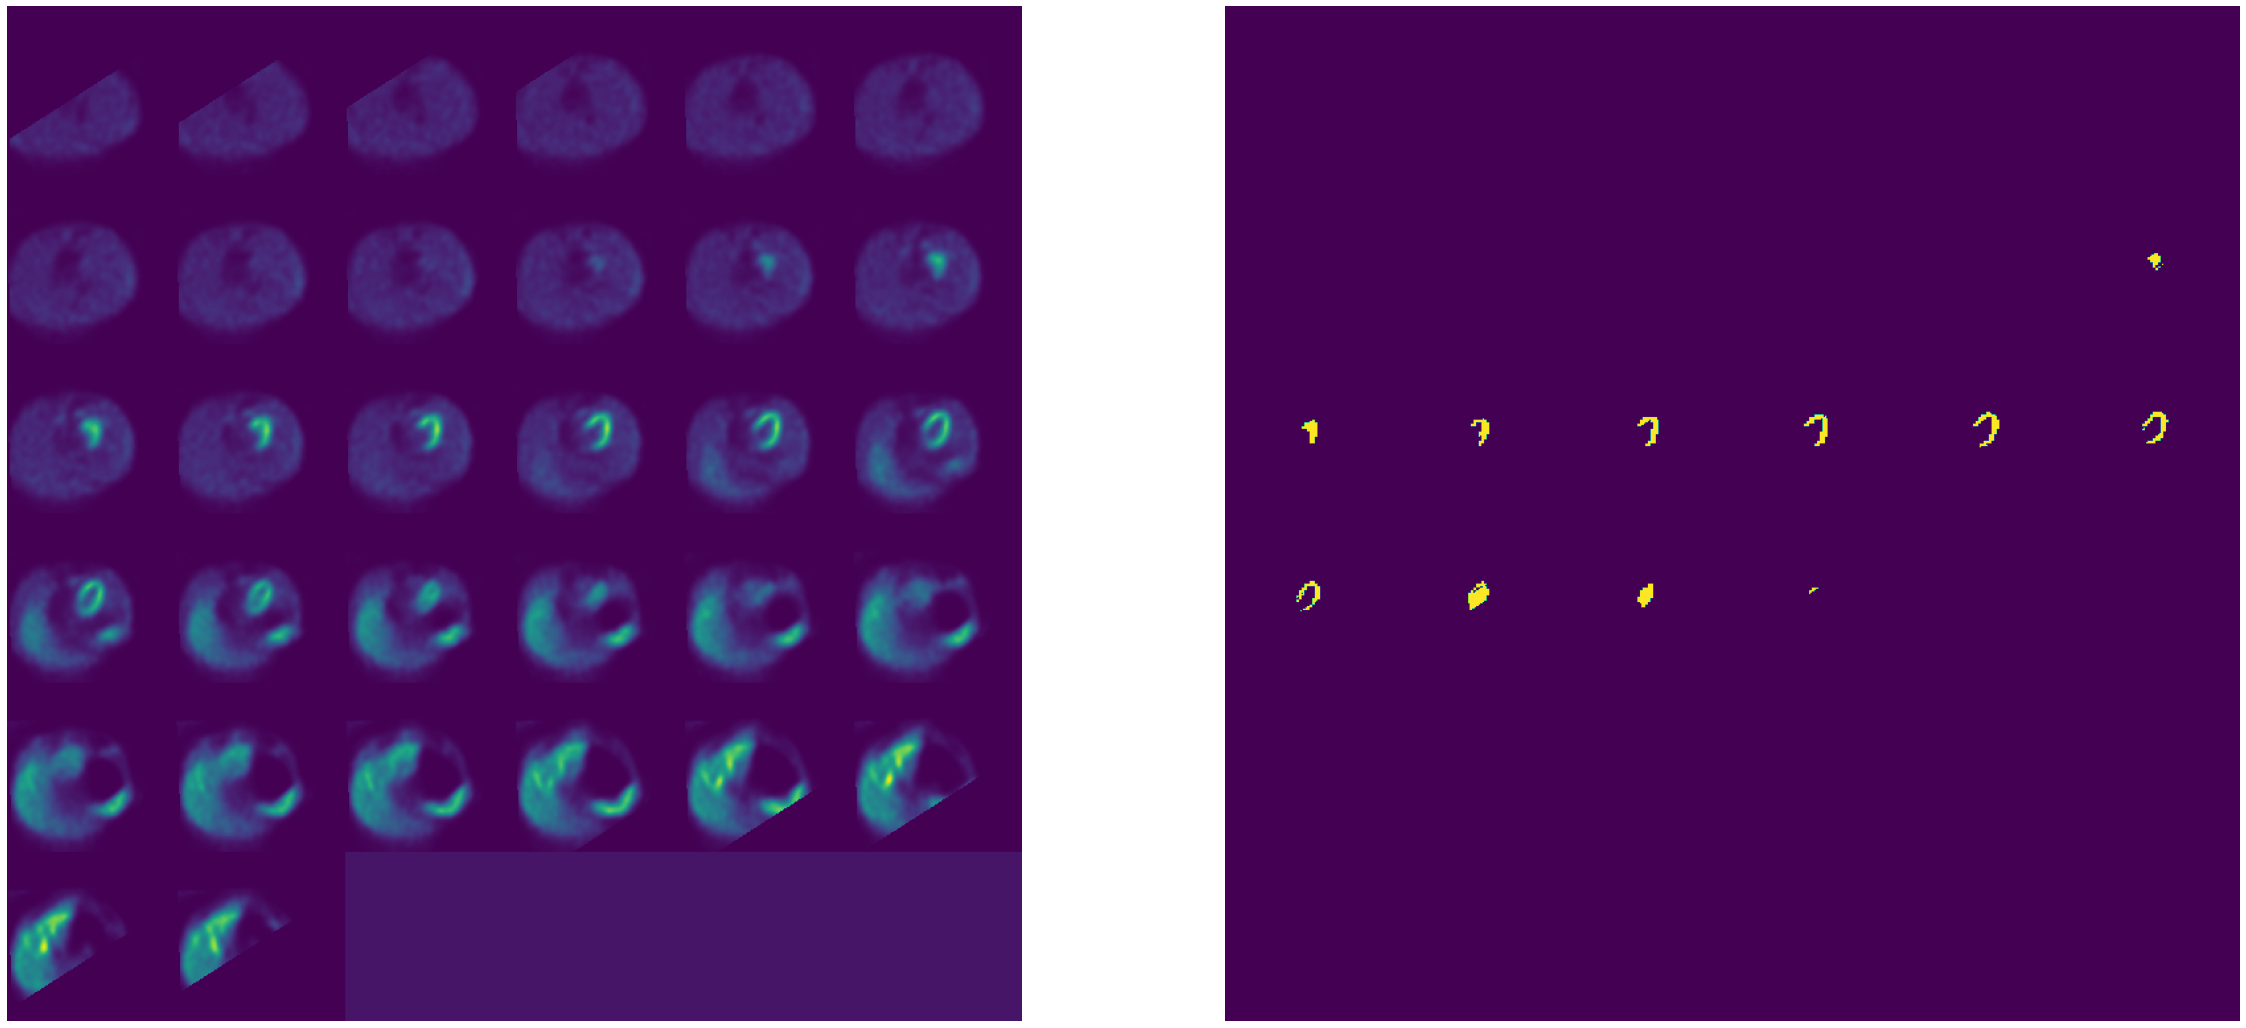

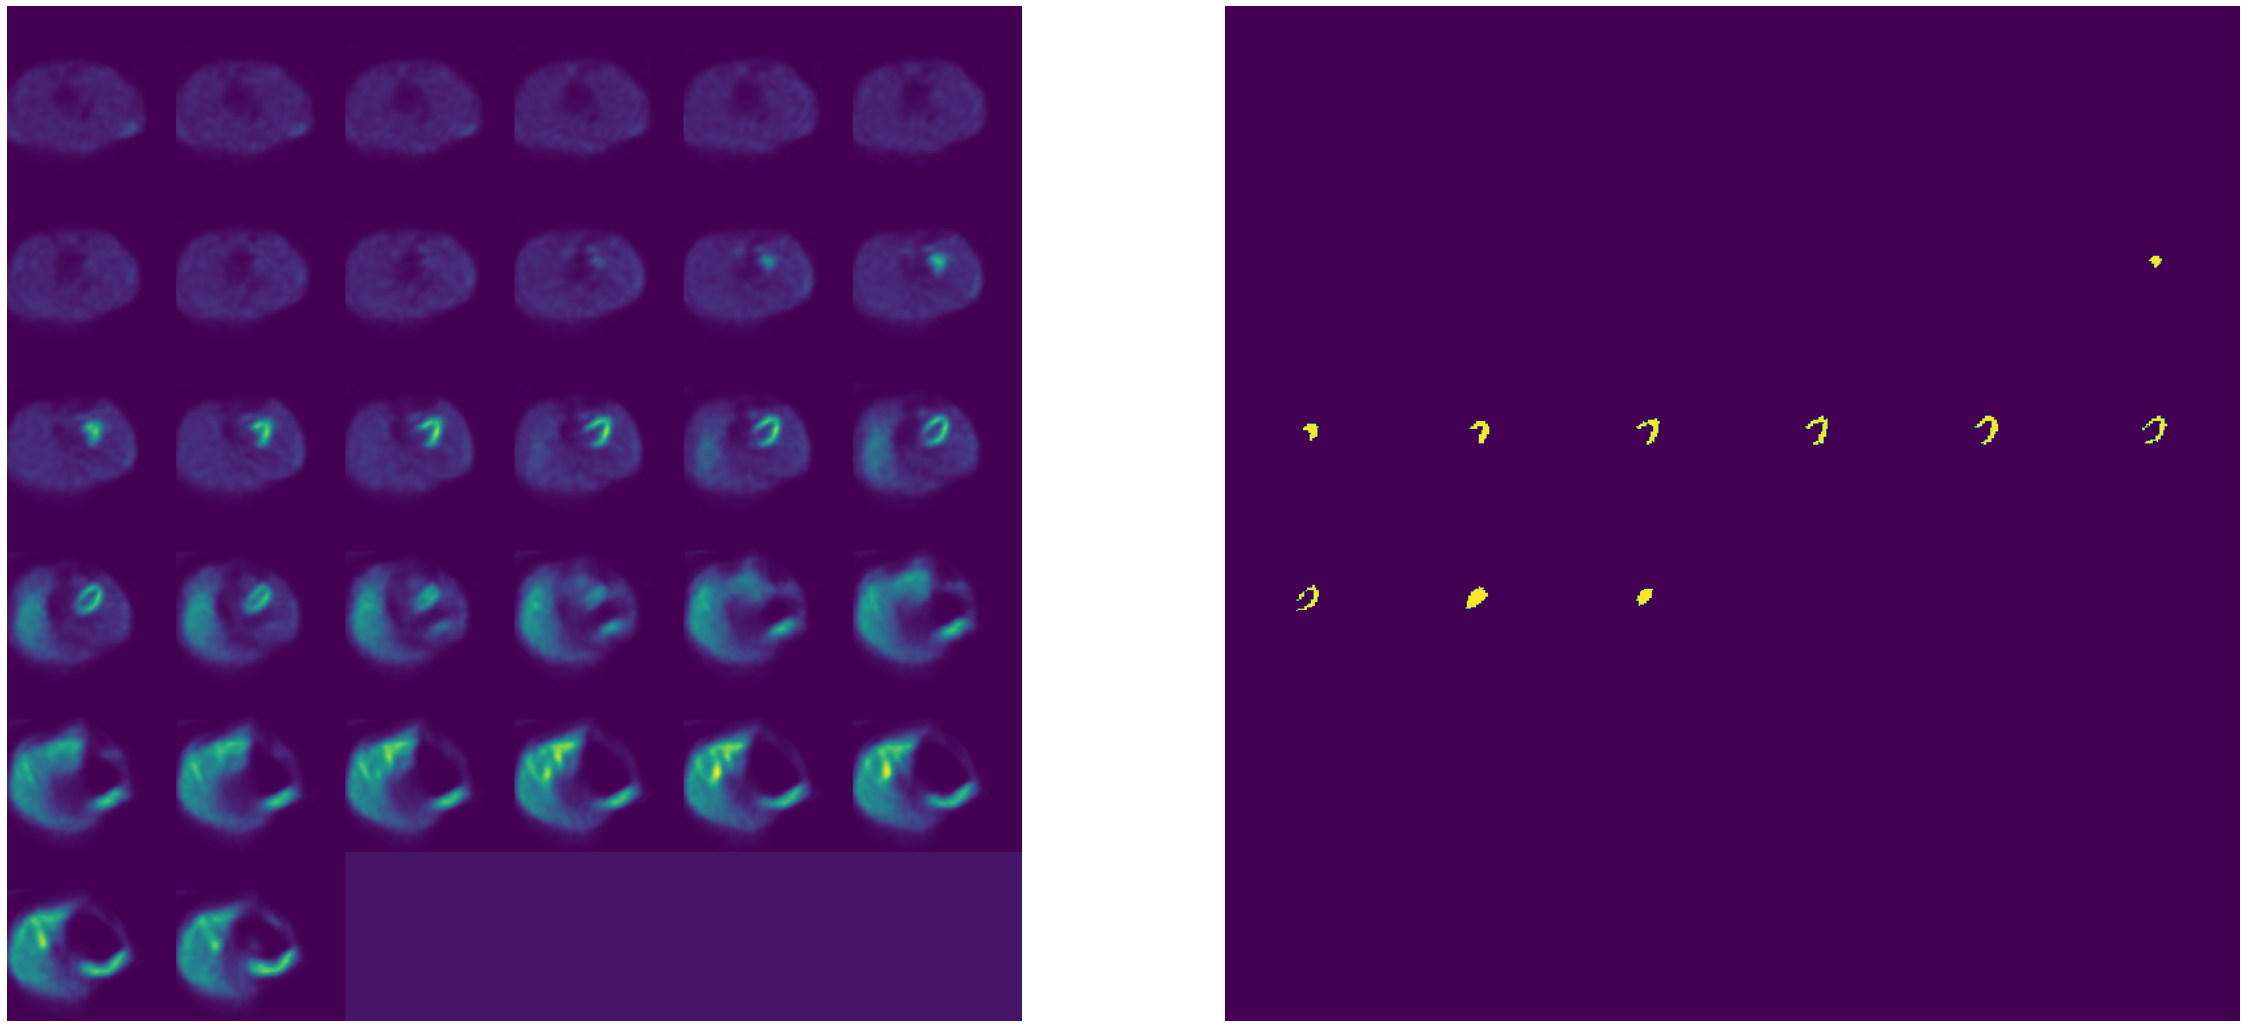

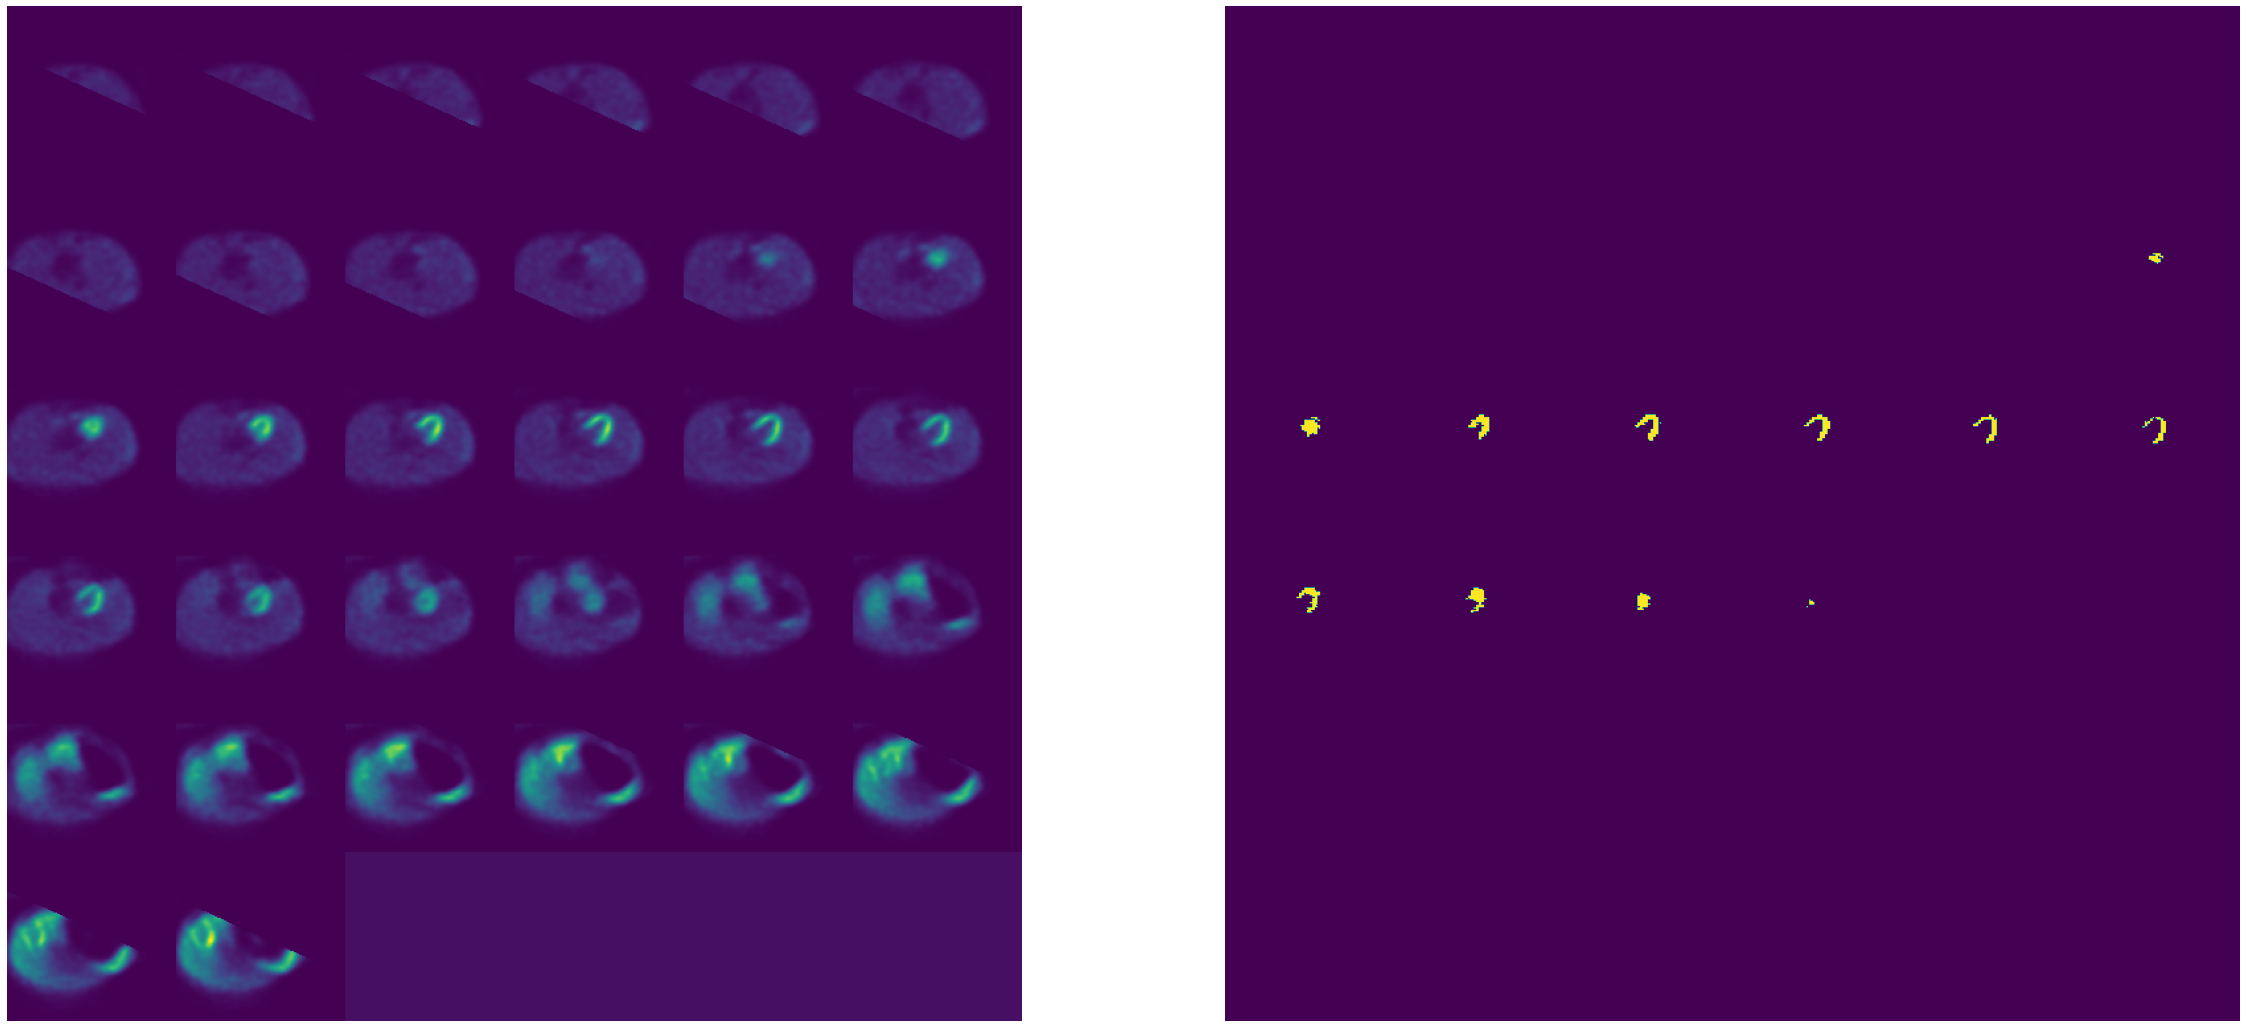

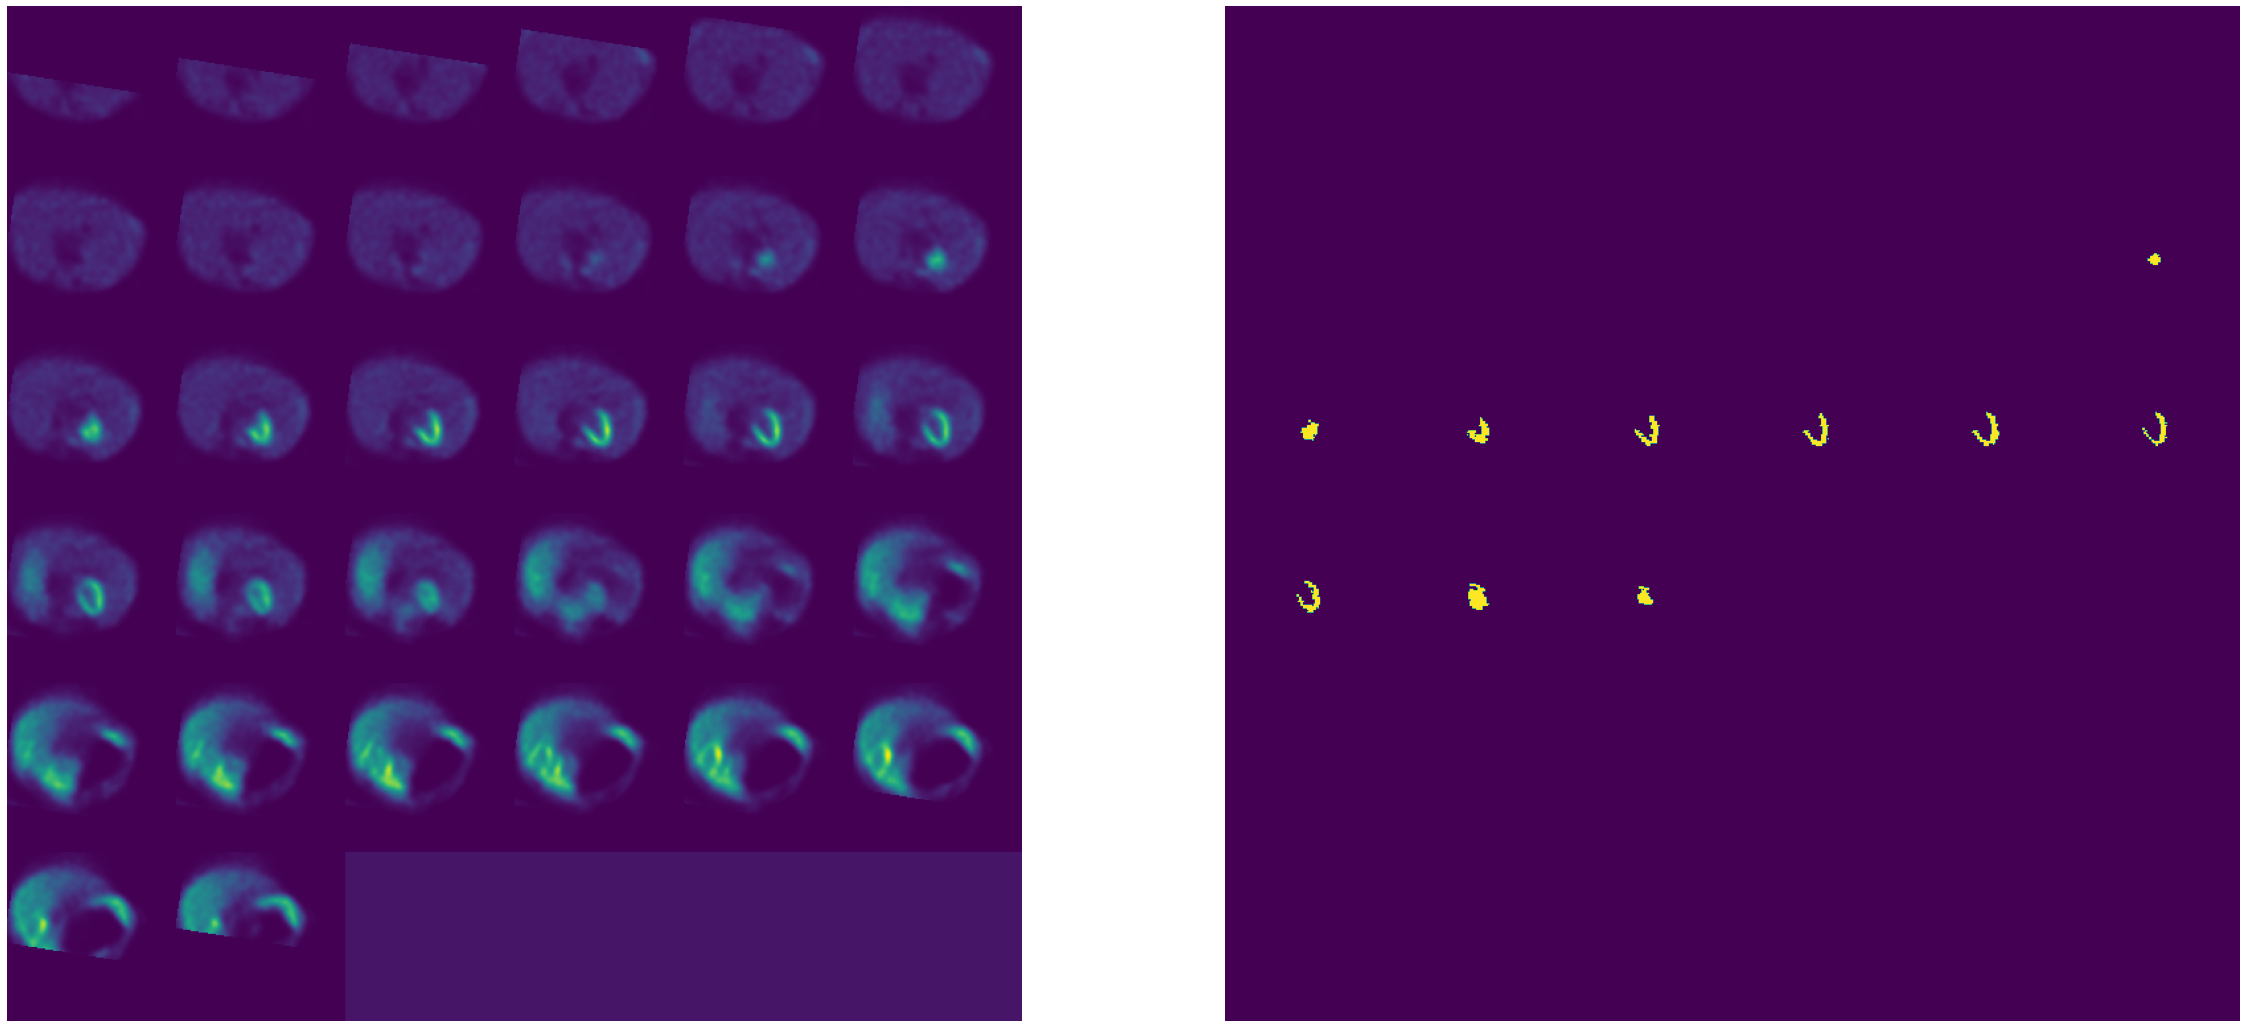

In [317]:
for i in range(10):
    
    transformed_subject = transformations(one_subject)
    
    image_transformed = transformed_subject.spect.data.numpy()
    mask_transformed = transformed_subject.left_ventricle.data.numpy()

    vis.visualize(
        np.squeeze(image_transformed).swapaxes(1, 2).swapaxes(0, 1), 
        np.squeeze(mask_transformed).swapaxes(1, 2).swapaxes(0, 1)
    )

## UniformSampler needs a Subject type, while tio.Compose transformations
## accept tensors. 
## Solution for self-supervised learning: when generating the subjects, if the D dimension
## is larger than the desired, generate X number of UniformSampled subjects

In [325]:
path_xyz = os.path.join(path_data, 'segmentation_xyz')

In [329]:
target_shape = (128, 128, 32)
random_crop = tio.data.UniformSampler(target_shape)
iter_rc = 10 

subjects_ssl = []

spect_data_ssl = list(map(lambda x: os.path.join(path_xyz, x), df['image'].tolist()))


for image_path in tqdm(spect_data_ssl):
    
    if subject.shape[-1] > target_shape[-1]:
        
        for i in range(iter_rc):

            subject = tio.Subject(
                spect=tio.ScalarImage(image_path),
            )
            subject = next(random_crop(subject))
            subjects_ssl.append(subject)
    else:
        subject = tio.Subject(
            spect=tio.ScalarImage(image_path),
        )
        subjects_ssl.append(subject)


dataset_ssl = tio.SubjectsDataset(subjects_ssl)

print(f"Dataset SSL size: {len(dataset_ssl)} subjects")

  0%|          | 0/102 [00:00<?, ?it/s]

Dataset SSL size: 561 subjects
